# Diabetes Risk Identification and Prediction (DRIP)

# About the Dataset
**Selected Variables Encoding Information**:  https://www.cdc.gov/pcd/issues/2019/19_0109.htm

**Codebook**: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

# Imports

In [590]:
import os
import pandas as pd
from ucimlrepo import fetch_ucirepo

import sweetviz as sv
import math
import pickle
import json

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
import re
from scipy.stats import pointbiserialr, spearmanr

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress the specific warning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from scipy.cluster.hierarchy import linkage, leaves_list

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


# Data Acquisition and Loading

In [596]:
data_dir = "data"  # You can change this to your preferred directory
feature_path = os.path.join(data_dir, "cdc_diabetes_data_features.pkl")
target_path = os.path.join(data_dir, "cdc_diabetes_data_targets.pkl")
metadata_path = os.path.join(data_dir, "cdc_diabetes_data_metadata.json")
variables_path = os.path.join(data_dir, "cdc_diabetes_data_variables.pkl")  # Changed to .pkl for pickle

def load_dataset():
    # Ensure the directory exists
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # Check if the dataset is already downloaded and saved locally
    if not (os.path.exists(feature_path) and os.path.exists(target_path) and 
            os.path.exists(metadata_path) and os.path.exists(variables_path)):
        
        # Assuming fetch_ucirepo is a function that downloads the dataset
        cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
        display(cdc_diabetes_health_indicators.keys())
        
        # Save the features, targets, metadata, and variables locally
        cdc_diabetes_health_indicators.data.features.to_pickle(feature_path)
        cdc_diabetes_health_indicators.data.targets.to_pickle(target_path)
        
        # Serialize metadata using JSON
        metadata = cdc_diabetes_health_indicators.metadata
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f)
        
        # Serialize variables using pickle
        variables = cdc_diabetes_health_indicators.variables
        with open(variables_path, 'wb') as f:
            pickle.dump(variables, f)
        
        print("Downloaded and saved the dataset locally.")
        features = cdc_diabetes_health_indicators.data.features
        targets = cdc_diabetes_health_indicators.data.targets

    else:
        # Load the features, targets, metadata, and variables from local storage
        features = pd.read_pickle(feature_path)
        targets = pd.read_pickle(target_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        with open(variables_path, 'rb') as f:
            variables = pickle.load(f)
        
        print("Loaded dataset from local storage.")

    return features, targets, metadata, variables

# Use the function to load your dataset
X, y, metadata, variables = load_dataset()

# Display metadata and variables to ensure they're correctly loaded
print("Metadata:", metadata)
display("Variables:", variables)
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score

import numpy as np

Loaded dataset from local storage.
Metadata: {'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values'

'Variables:'

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in you...,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not includ...,None,no


In [526]:
display(X)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,18,0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,1,28,0,0,0,1,1,0,...,1,0,1,0,0,0,0,2,5,2
253678,1,0,1,23,0,0,0,0,1,1,...,1,0,3,0,0,0,1,7,5,1


In [527]:
display(y)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,1
253677,0
253678,0


# SweetViz


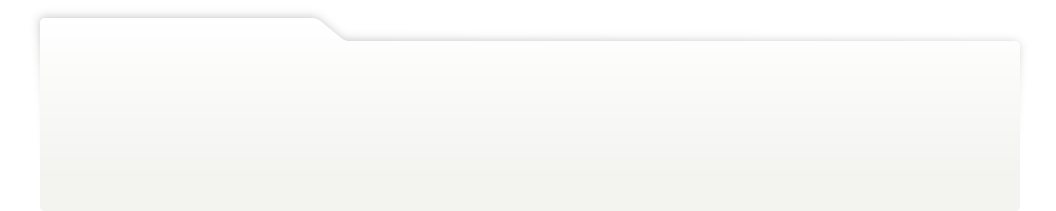
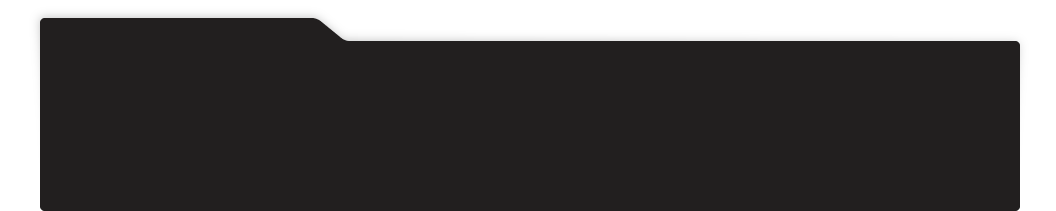
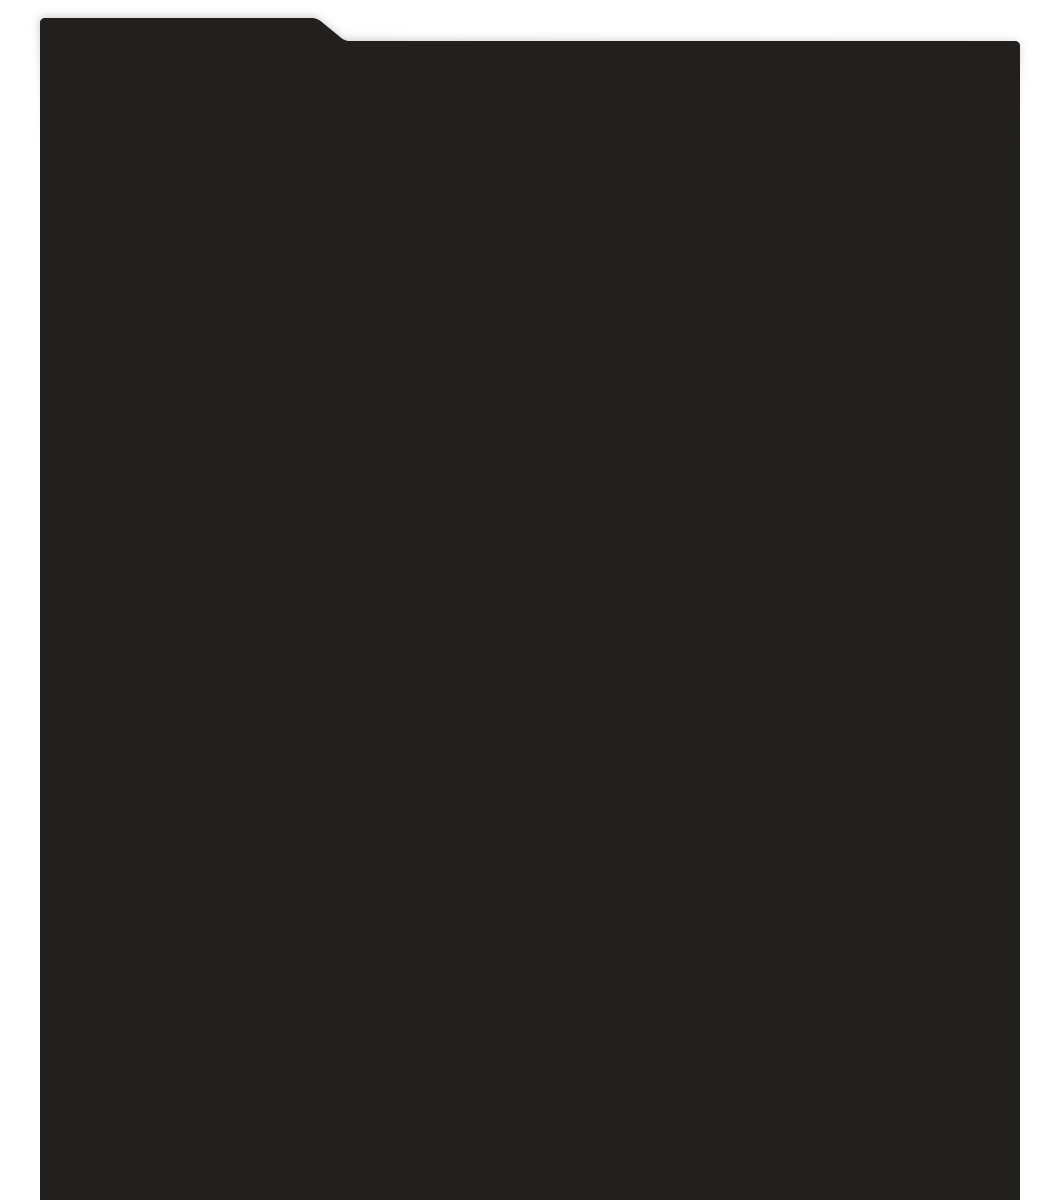
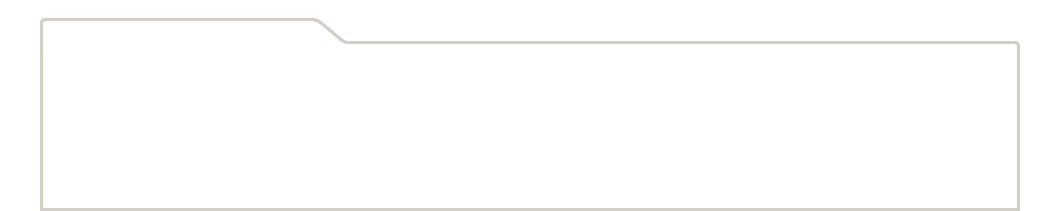
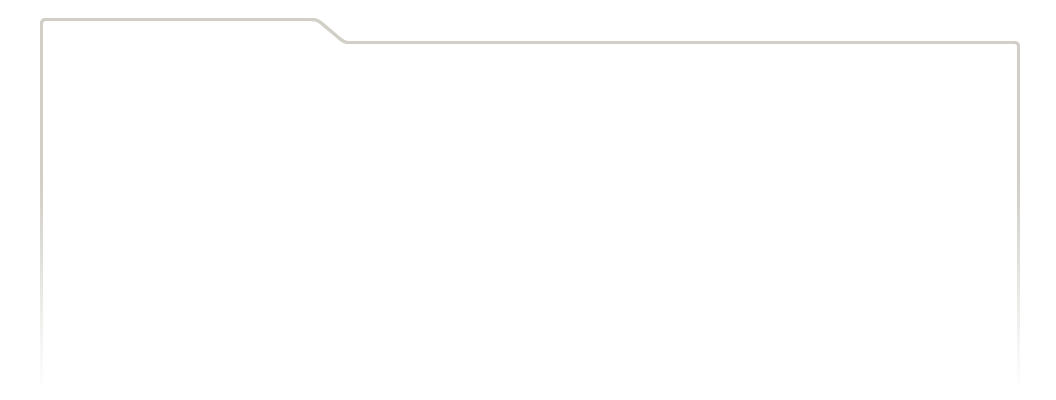
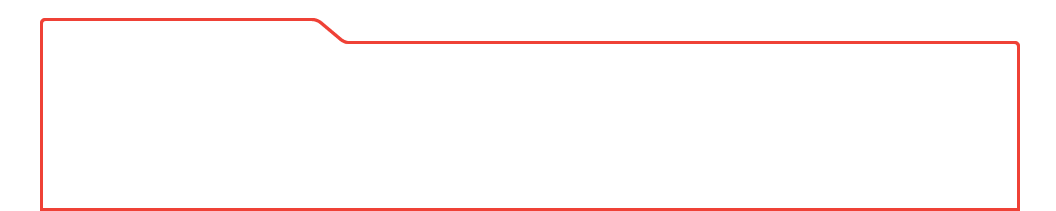
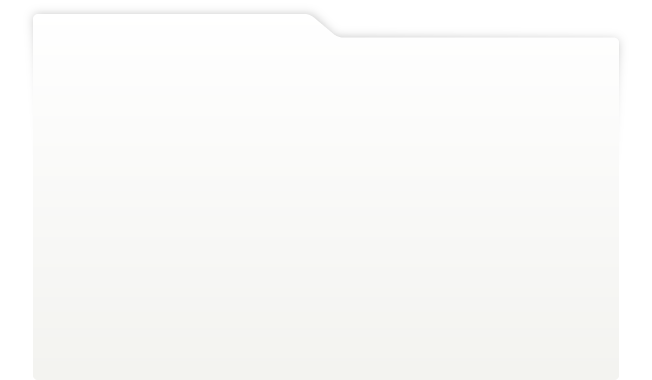
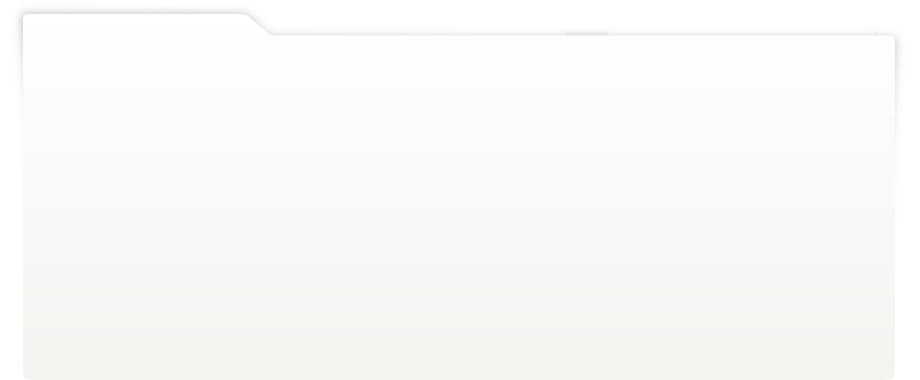
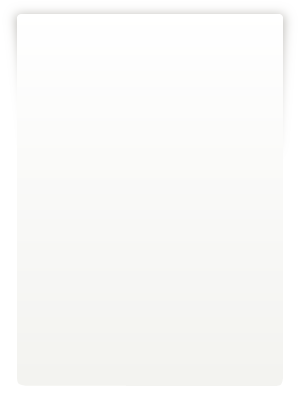
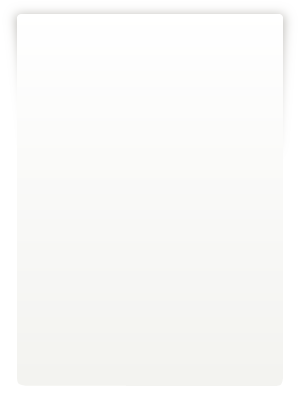
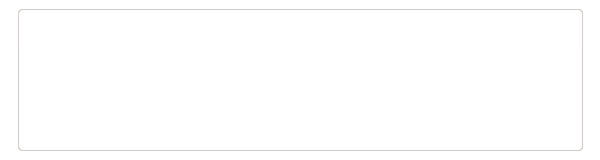
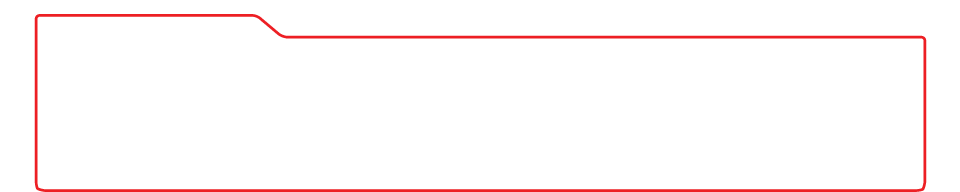
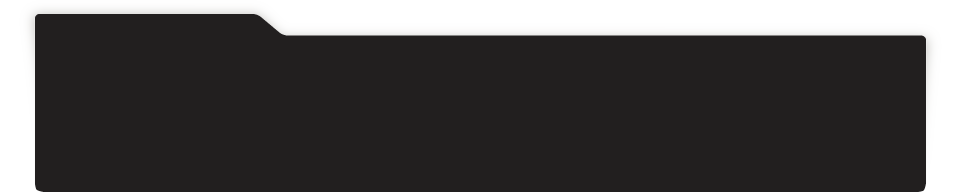
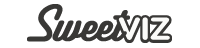
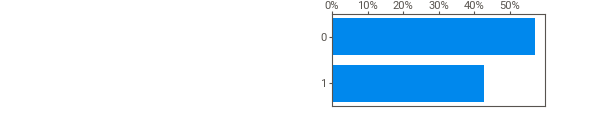
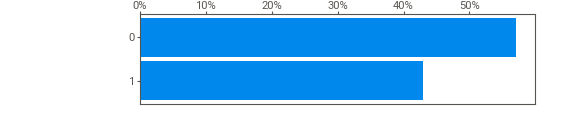
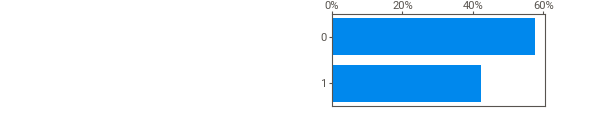
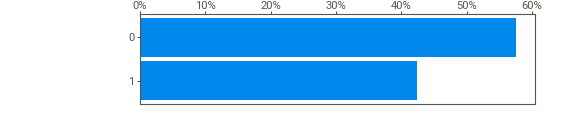
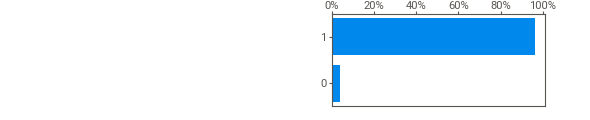
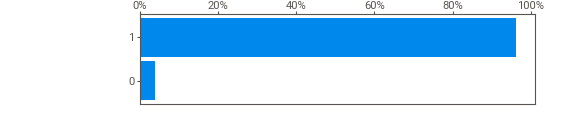
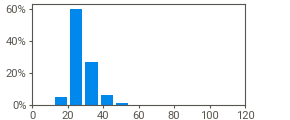
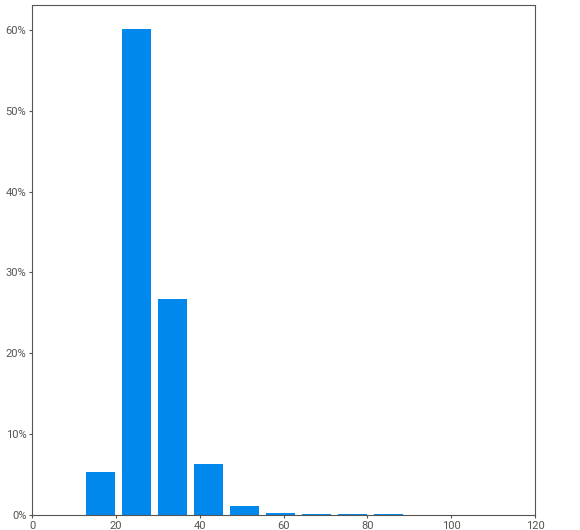
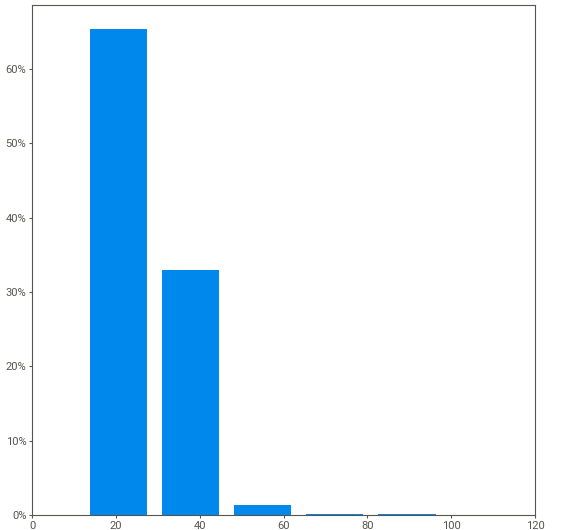
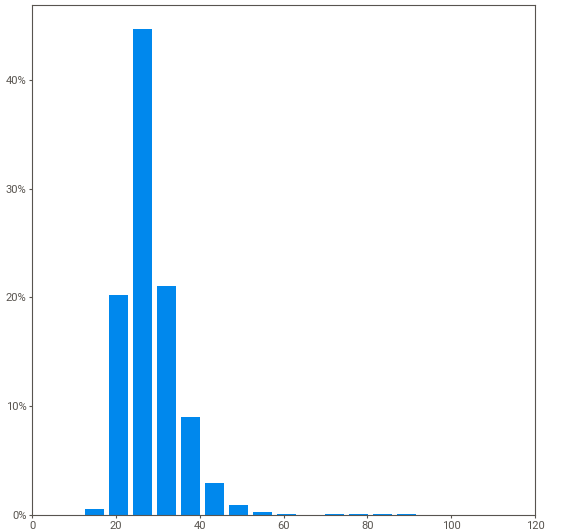
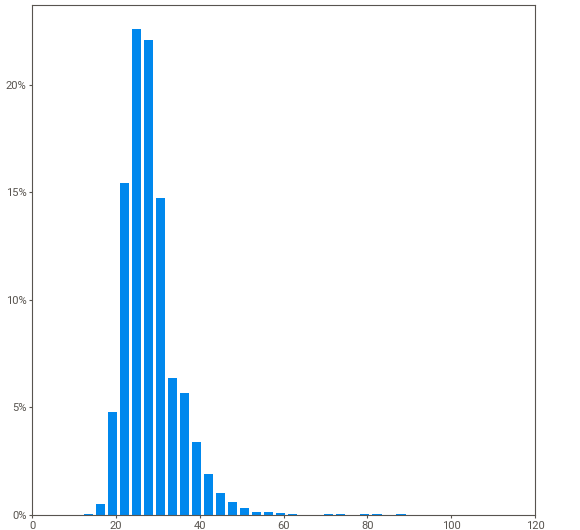
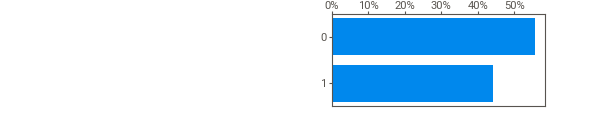
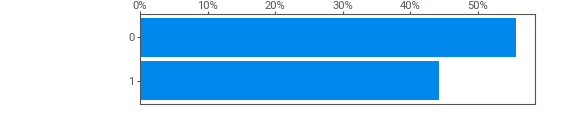
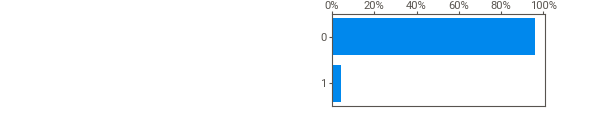
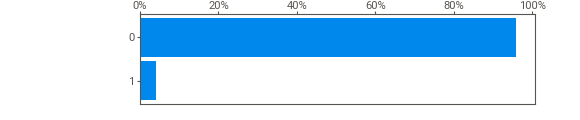
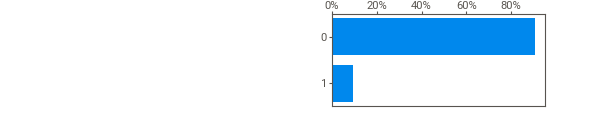
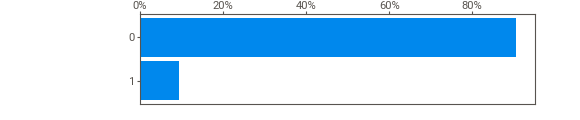
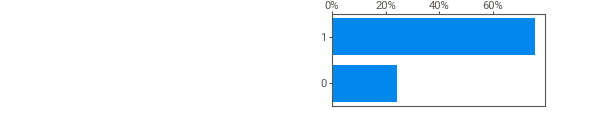
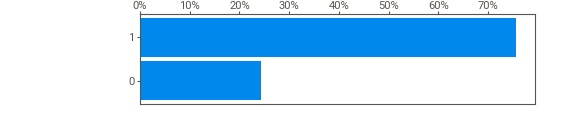
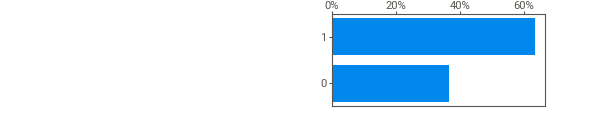
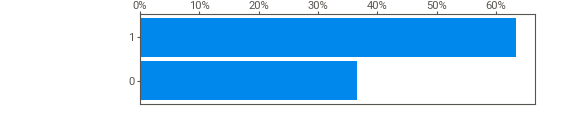
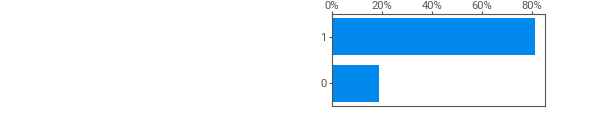
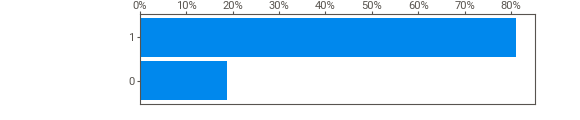
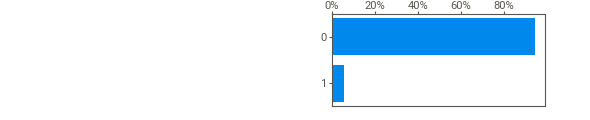
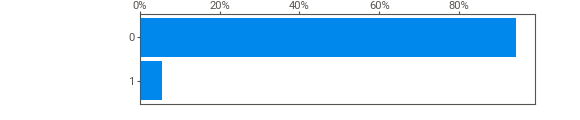
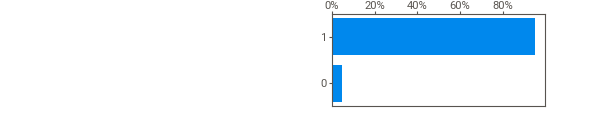
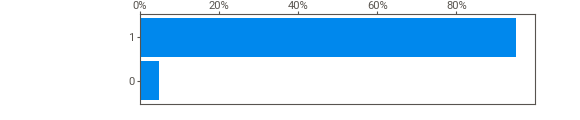
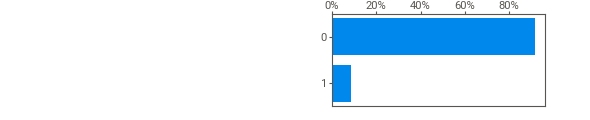
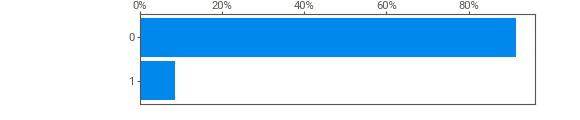
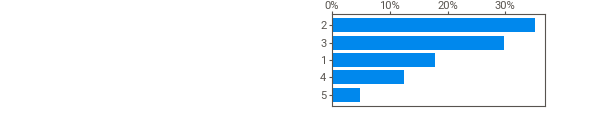
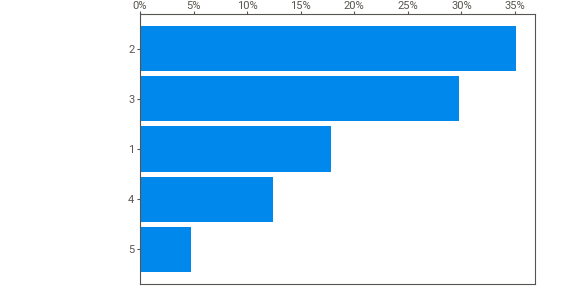
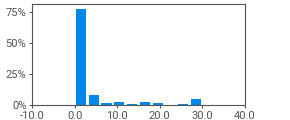
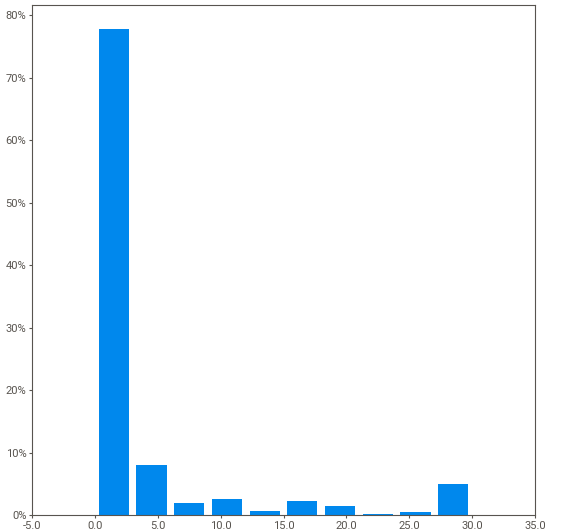
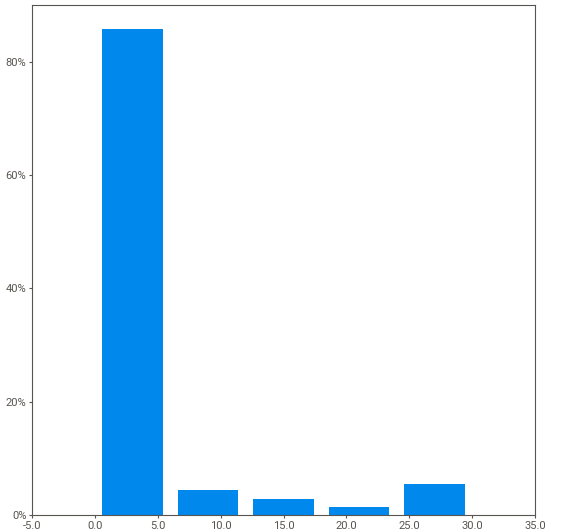
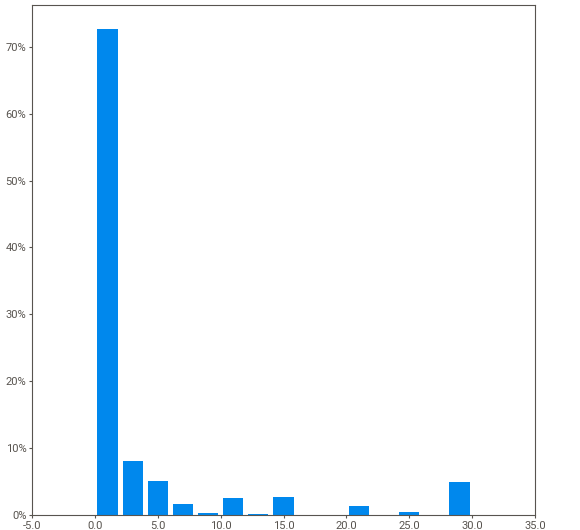
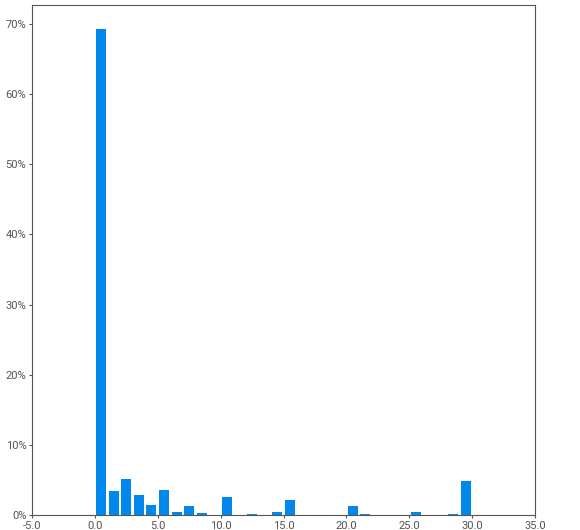
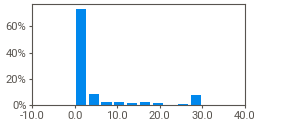
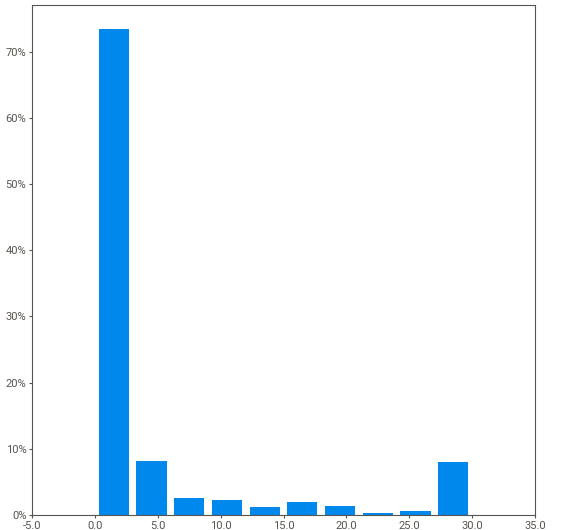
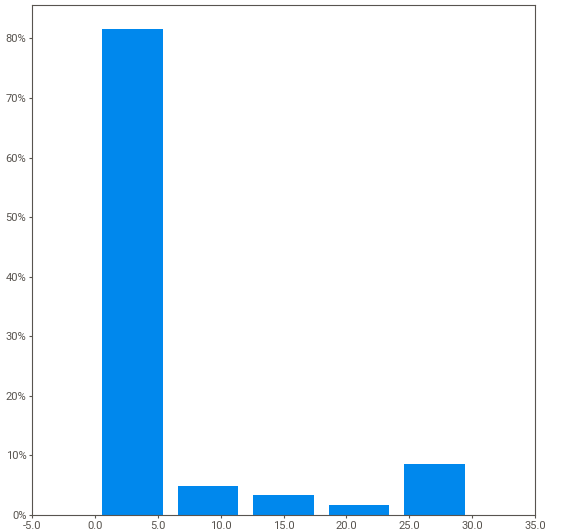
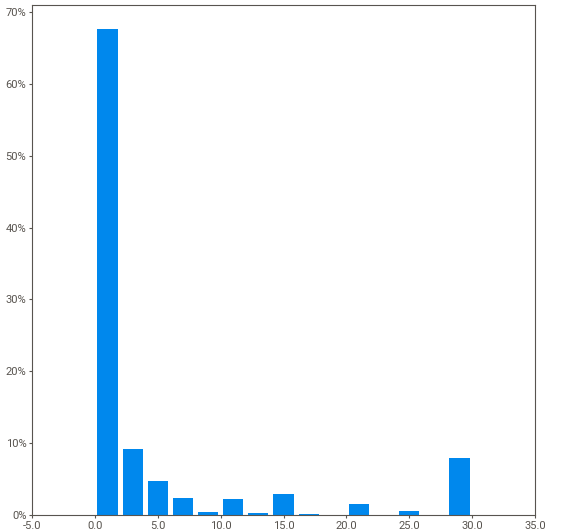
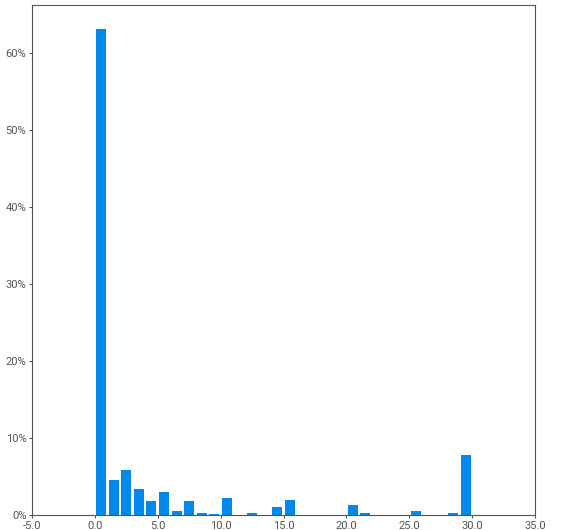
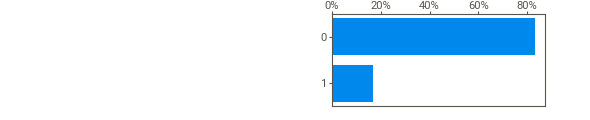
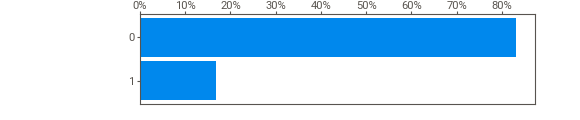
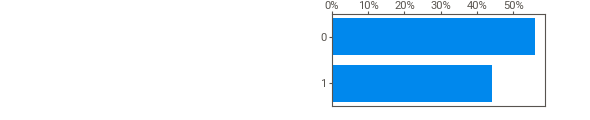
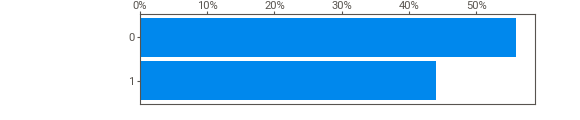
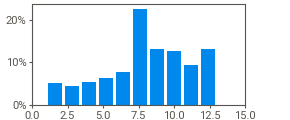
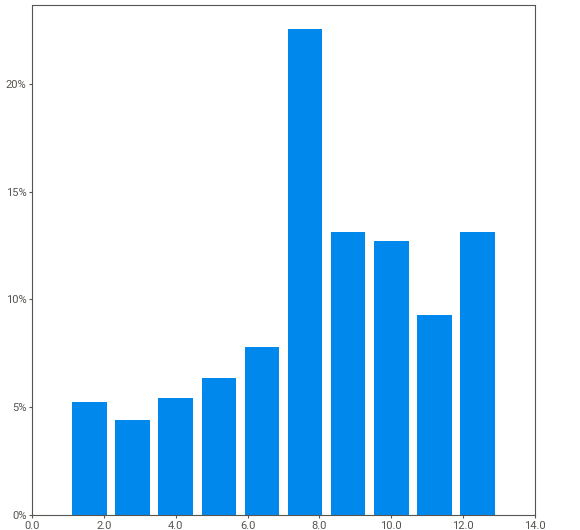
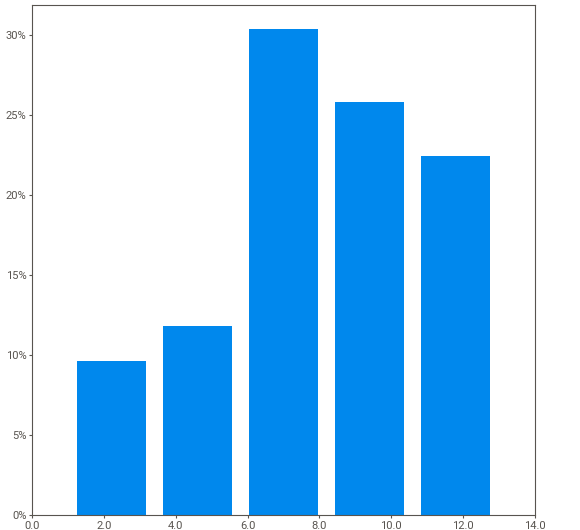
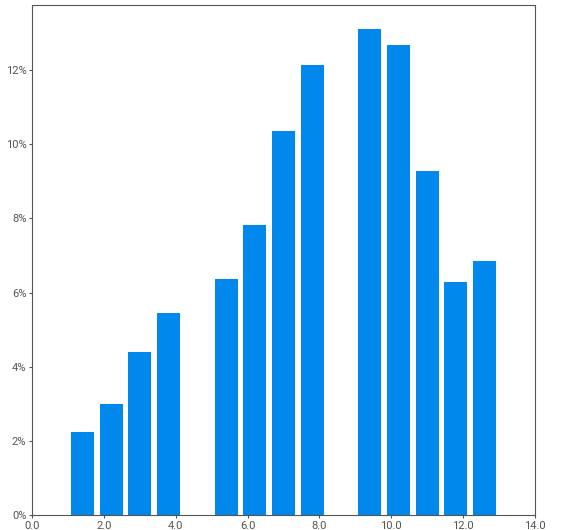
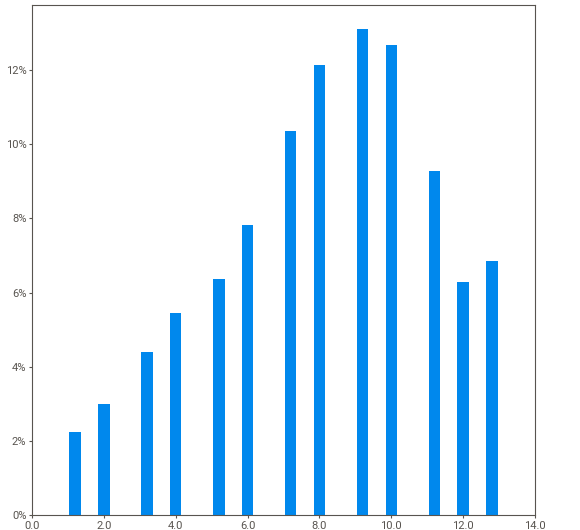
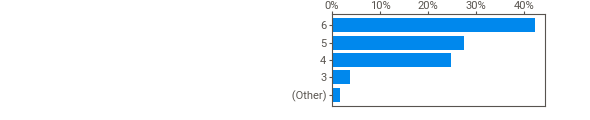
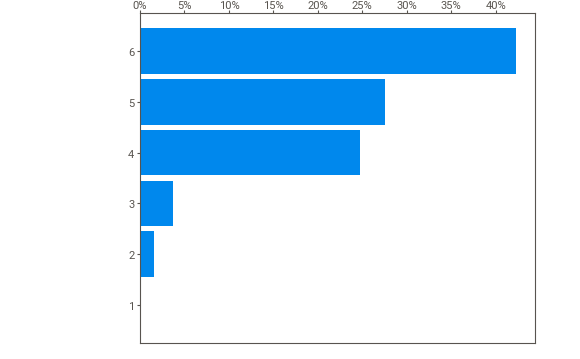
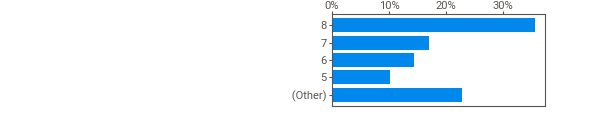
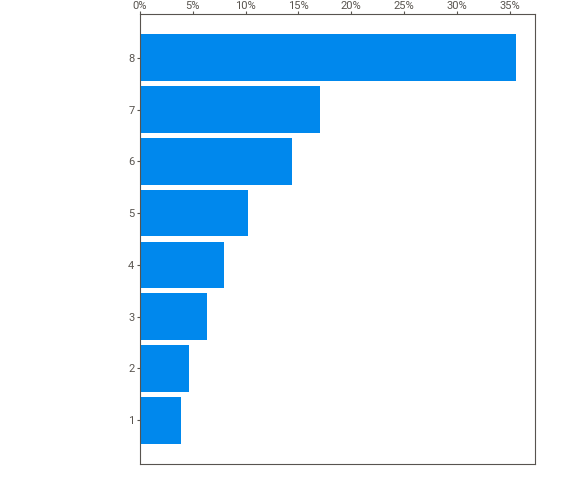
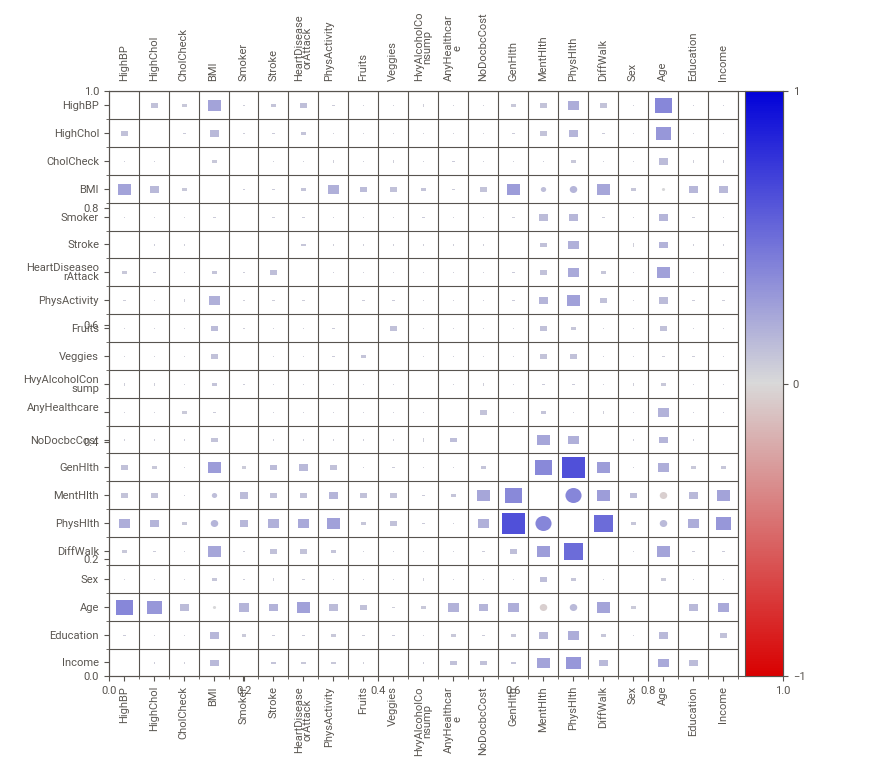
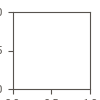

In [528]:
if 'report' not in globals():
    # Generate a Sweetviz report
    report = sv.analyze(X)

# Save the report to an HTML file
#report.show_html("sweetviz_report.html")
report.show_notebook()

# EDA and Data Prep


## Missing Values
There are no missing values!  This will save us a big headache.  

There are some that are less informative though.  (Other) exists in `Income` and `Education`

## Distinct and Data Types
Many values are binary.  Distinct also shows missingness isn't encoded for binary so the missing values really just don't exist.


### Binary
Since I verified they don't have missing this should be an easy check
`HighBP`,
 `HighChol`,
 `CholCheck`,
 `Smoker`,
 `Stroke`,
 `HeartDiseaseorAttack`,
 `PhysActivity`,
 `Fruits`,
 `Veggies`,
 `HvyAlcoholConsump`,
 `AnyHealthcare`,
 `NoDocbcCost`,
 `DiffWalk`,
 `Sex`
 are the binary columns

In [529]:
unique_counts = X.nunique()
bin_cols = unique_counts[unique_counts == 2].index.tolist()
bin_cols

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'DiffWalk',
 'Sex']

### Continuous

`BMI`, `PhysHlth`, `MentHlth`
These columns can't be encoded as anything they just are what they are.

In [530]:
cont_cols = ['BMI','PhysHlth','MentHlth']
cont_cols

['BMI', 'PhysHlth', 'MentHlth']

### Discrete
`GenHlth`, `Age`, `Education`, `Income`
Age was binned so it is discrete here.  Education and Income are categories already encoded.

In [531]:
disc_cols = ['GenHtlh','Age','Education','Income']

### Validate Cols 

In [532]:
all_cols = bin_cols + disc_cols + cont_cols
display(len(all_cols))
if all_cols.sort() == X.columns.to_list().sort():
    print("\n All Columns Categorized")

21


 All Columns Categorized


## Duplicates
Why are there so many duplicate rows?

In [533]:
X[X.duplicated()]

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,1,1,1,27,1,0,0,0,0,1,...,1,0,5,0,30,1,0,10,4,5
1563,0,0,1,21,1,0,0,1,1,1,...,1,0,1,0,0,0,0,4,6,8
2700,0,0,1,32,0,0,0,1,1,1,...,1,0,2,0,0,0,0,5,6,8
3027,1,0,1,38,0,0,0,1,1,1,...,1,0,3,0,0,0,1,7,6,8
3160,0,0,1,21,0,0,0,1,1,1,...,1,0,1,0,0,0,0,4,6,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,1,1,1,33,0,0,0,1,1,1,...,1,0,3,0,0,0,1,9,6,6
253550,0,0,1,25,0,0,0,1,1,1,...,1,0,1,0,0,0,0,7,6,8
253563,0,1,1,24,1,0,0,1,1,1,...,1,0,2,0,0,0,1,8,6,8
253597,0,0,1,24,0,0,0,1,1,1,...,1,0,2,0,0,0,0,5,6,8


### Statistically Likely?

In [534]:
X.duplicated().sum() / len(X)

0.10159255755282245

10% of rows being duplicate among how many features is how likely?

Lets assume they are all binary to just make the math easy

### Broad Estimate

In [535]:
num_combinations = 1
for column in X.columns:
    distinct_values = X[column].nunique()
    num_combinations *= distinct_values

print(f"Total number of unique combinations possible: {num_combinations:,}")

Total number of unique combinations possible: 4,126,455,889,920


In [536]:
n = len(X)
# Calculating the expected number of duplicates
expected_duplicates = (n * (n - 1)) / (2 * num_combinations)
print(f"Expected number of duplicate rows: {expected_duplicates:,}")

Expected number of duplicate rows: 0.007797646507890773


### There shouldn't be any duplicates but 10% of the dataset has them
The expected duplicates being close to zero strongly indicates that having 10% of the dataset be duplicates is extremely unlikely by chance.  So there has to be another reason.

The duplicates could be for a slew of reasons, such as sampling strategies in surveys, repeated surveys including the same people or errors in aggergating surveys with scripts.

In any case, I should either delete all of them or keep only 1 of each.  Since their data integrity is in quesiton and there's so many rows I can just drop them.

In [537]:
drop_masq = X.duplicated()
y = y[~drop_masq]
X = X[~drop_masq]
X.duplicated().sum()

0

## Data Type Checking

In [538]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  int64
 1   HighChol              227908 non-null  int64
 2   CholCheck             227908 non-null  int64
 3   BMI                   227908 non-null  int64
 4   Smoker                227908 non-null  int64
 5   Stroke                227908 non-null  int64
 6   HeartDiseaseorAttack  227908 non-null  int64
 7   PhysActivity          227908 non-null  int64
 8   Fruits                227908 non-null  int64
 9   Veggies               227908 non-null  int64
 10  HvyAlcoholConsump     227908 non-null  int64
 11  AnyHealthcare         227908 non-null  int64
 12  NoDocbcCost           227908 non-null  int64
 13  GenHlth               227908 non-null  int64
 14  MentHlth              227908 non-null  int64
 15  PhysHlth              227908 non-null  

Many of these are boolean but all are in int64 lets fix that

### Binary Cols Should be Boolean

In [539]:
X[bin_cols] = X[bin_cols].astype('bool')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  int64
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  int64
 14  MentHlth              227908 non-null  int64
 15  PhysHlth              227908 non-null  

### max value of int64 checks
We can improve memory usage and computation speed if we lower the values to their sizes

In [540]:
int_cols = X.select_dtypes('int64').columns.to_list()
for col in int_cols:
    print(f"{col} range is {X[col].min()} - {X[col].max()}")

BMI range is 12 - 98
GenHlth range is 1 - 5
MentHlth range is 0 - 30
PhysHlth range is 0 - 30
Age range is 1 - 13
Education range is 1 - 6
Income range is 1 - 8


In [541]:
int_cols

['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

### Cast to uint8
They are all less than 255 by a lot, which means uint8 is big enough for them.

In [542]:
cast_dict = {}
for col in int_cols:
    cast_dict[col] = 'uint8'
display(cast_dict)
X = X.astype(cast_dict)
X.info()

{'BMI': 'uint8',
 'GenHlth': 'uint8',
 'MentHlth': 'uint8',
 'PhysHlth': 'uint8',
 'Age': 'uint8',
 'Education': 'uint8',
 'Income': 'uint8'}

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  uint8
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  uint8
 14  MentHlth              227908 non-null  uint8
 15  PhysHlth              227908 non-null  

### Analysis of Casting
great! we went from `memory usage: 38.3 MB` to `memory usage: 6.3 MB` with zero information loss!  Feels great.  This should really help our model training and efficiency overall, as well as let models with special handling of booleans benefit from it!

## Int Cols Distributions and Class Imbalances
I need to analyze the distributions of all the int cols

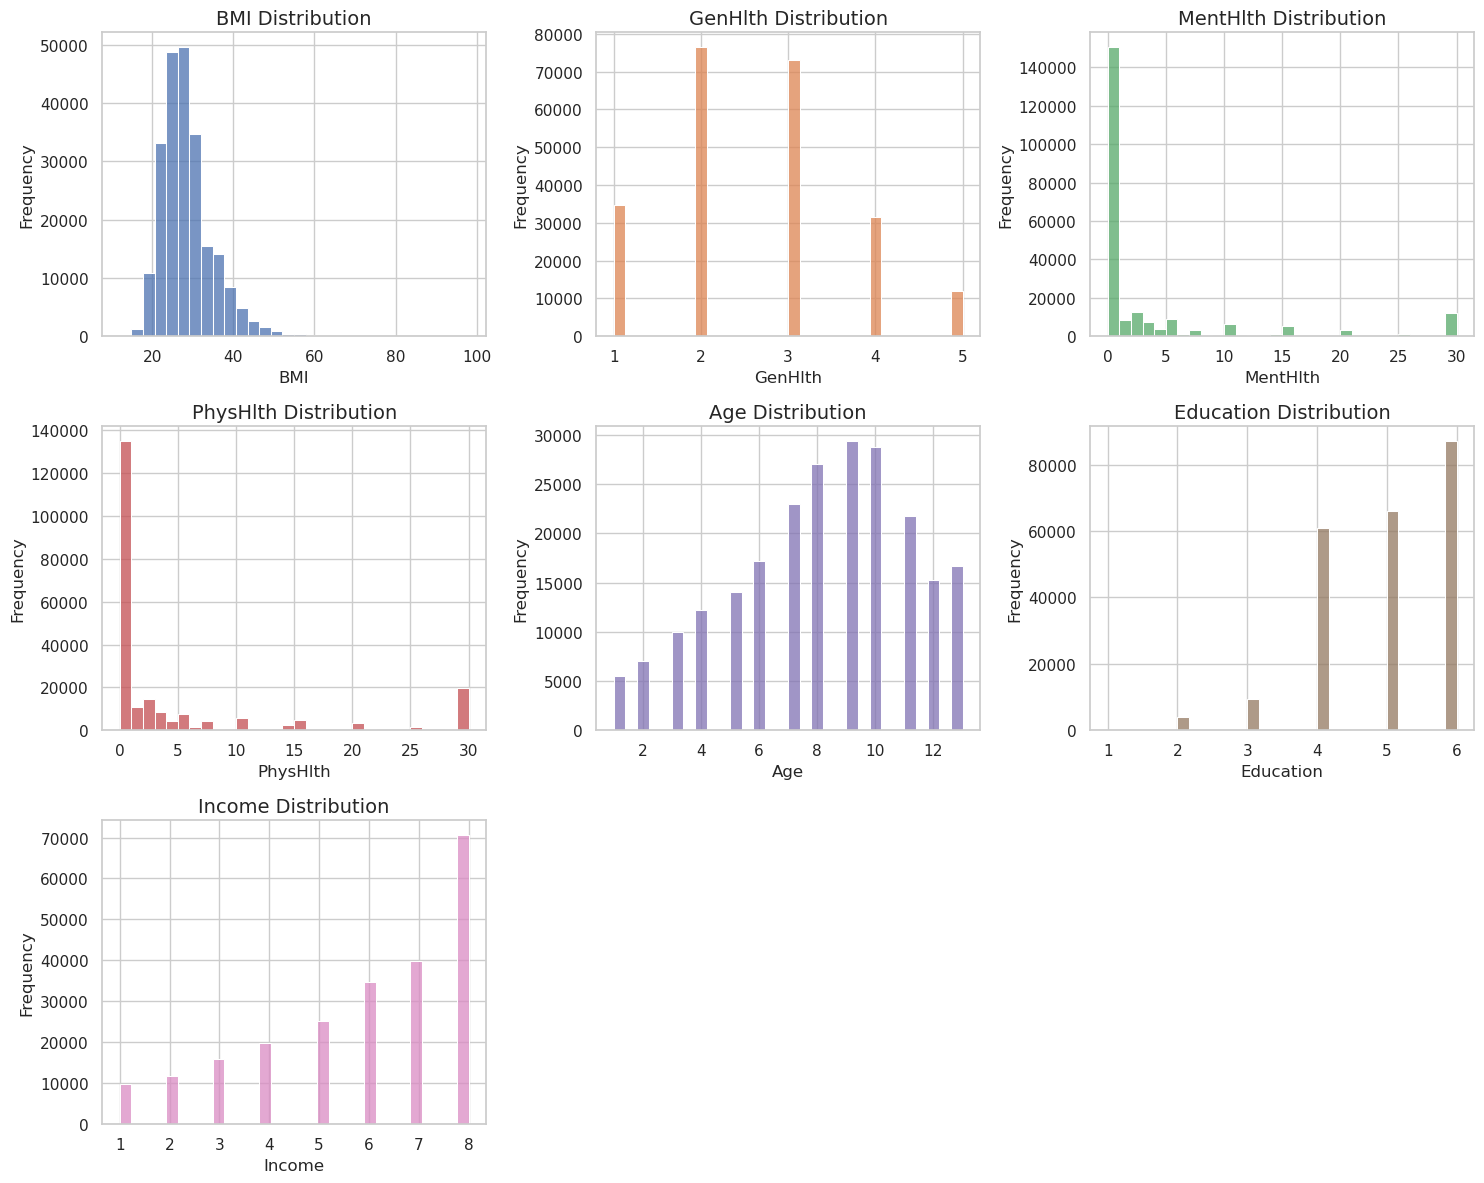

In [543]:
def hist_plot_cols(cols):
    # Set the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("deep",n_colors=len(cols))

    # Create a grid of plots (3x3 grid to accommodate all the columns)
    n_rows = 3
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot histograms for each integer column with different colors
    for i, col in enumerate(cols):
        sns.histplot(X[col], ax=axes[i], kde=False, color=palette[i], bins=30)
        axes[i].set_title(f'{col} Distribution', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].grid(True)

    # Remove any unused subplots (if any)
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()
hist_plot_cols(int_cols)

In [544]:
do_rebins = True

#### BMI
BMI has a skewed distribution, the number of people really overweight are probably outliers.

#### GenHlth
Lets see what the encodings mean

In [545]:
def display_variable_desc(varname):
    # Extract the description of the 'GenHlth' variable
    vardesc = variables[variables['name'] == varname]['description'].values[0]
    # Display it nicely in a notebook using Markdown
    display(Markdown(f"**{varname} Description:**\n\n{vardesc}"))
display_variable_desc('GenHlth')

**GenHlth Description:**

Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

It seems most people rate their health very good or good.  Since this is an encoding the distribution is more of a classification.

#### MentHlth

In [546]:
display_variable_desc('MentHlth')
X['MentHlth'].value_counts(normalize=True).head()

**MentHlth Description:**

Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days

MentHlth
0     0.661574
2     0.055650
30    0.052999
5     0.039090
1     0.036423
Name: proportion, dtype: float64

66% of people say 0 days of their mental health was not good in the last month.
So a pretty big imbalance.  Consider binning since there's so few people in each bin other than 0.

##### Bin MentHlth

In [547]:
if do_rebins:
    # Create the bins and labels
    bins = [-1, 0, 7, 30]  # -1 to include 0 in its own bin
    labels = [1, 2, 3]  # 1 for 0, then 2, 3, 4 for the other bins

    # Apply the binning to the MentHlth column
    X['MentHlth_binned'] = pd.cut(X['MentHlth'], bins=bins, labels=labels, include_lowest=True)

    # Display the resulting binned column
    print(X[['MentHlth', 'MentHlth_binned']].head())

   MentHlth MentHlth_binned
0        18               3
1         0               1
2        30               3
3         0               1
4         3               2


In [548]:
if do_rebins:
    X['MentHlth_binned'].value_counts(normalize=True).head()

I have binned it into 
1: people who have zero mental health issues
2: people who reported 1-7 days with mental health issues in a month
3: people who reported 8-30 days with mental health issues in a month

The reason for this is two fold.  One is class balance, the other is, it's basically very healthy, struggling, and miserable.


#### PhysHlth

In [549]:
display_variable_desc('PhysHlth')
X['PhysHlth'].value_counts(normalize=True).head()

**PhysHlth Description:**

Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days

PhysHlth
0     0.592599
30    0.085030
2     0.063495
1     0.048533
3     0.036989
Name: proportion, dtype: float64

#### Bin PhysHlth

In [550]:
if do_rebins:
    # Create the bins and labels
    bins = [-1, 0, 7, 30]  # -1 to include 0 in its own bin
    labels = [1, 2, 3]  # 1 for 0, then 2, 3, 4 for the other bins

    # Apply the binning to the PhysHlth column
    X['PhysHlth_binned'] = pd.cut(X['PhysHlth'], bins=bins, labels=labels, include_lowest=True)

    # Display the resulting binned column
    print(X[['PhysHlth', 'PhysHlth_binned']].head())

   PhysHlth PhysHlth_binned
0        15               3
1         0               1
2        30               3
3         0               1
4         0               1


In [551]:
if do_rebins:
    X['PhysHlth_binned'].value_counts(normalize=True).head()

Same reasoning as with Mental Health

#### Age

In [552]:
display_variable_desc('Age')
X['Age'].value_counts(normalize=True).head()

**Age Description:**

13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older

Age
9     0.129004
10    0.126051
8     0.118807
7     0.100892
11    0.095464
Name: proportion, dtype: float64

Age looks great for our needs.  It is slightly not normal but it's ok.

#### Education

In [553]:
display_variable_desc('Education')
X['Education'].value_counts(normalize=True).head()

**Education Description:**

Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)

Education
6    0.382611
5    0.290078
4    0.267283
3    0.041539
2    0.017726
Name: proportion, dtype: float64

1 is an empty class we can just get rid of it

2 and 3 are super small consider binning

4,5, and 6 are fine but we can make this a better encoding by rebinning

##### Rebinning Education

In [554]:
if do_rebins:
    education_mapping = {
        1: 1,  # Combine these three into a single bin
        2: 1,
        3: 1,
        4: 2,  # Keep the original class for 4, 5, and 6, but reassign them to new values
        5: 3,
        6: 4
    }

    # Apply the mapping to the Education column
    X['Education_binned'] = X['Education'].map(education_mapping)

    # Display the resulting binned column
    print(X[['Education', 'Education_binned']].head())

   Education  Education_binned
0          4                 2
1          6                 4
2          4                 2
3          3                 1
4          5                 3


That's better!

In [555]:
if do_rebins:
    X['Education_binned'].value_counts(normalize=True).head()

#### Income

In [556]:
display_variable_desc('Income')
X['Income'].value_counts(normalize=True)

**Income Description:**

Income scale (INCOME2 see codebook) scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

Income
8    0.310046
7    0.174921
6    0.152588
5    0.110782
4    0.087377
3    0.069769
2    0.051560
1    0.042956
Name: proportion, dtype: float64

More imbalances and less meaningful categories.  Lets fix it.

##### Rebin Income

In [557]:
if do_rebins:
    income_mapping = {
        1: 1, 
        2: 1,
        3: 1,
        4: 1, 
        5: 2,
        6: 2,
        7: 3,
        8: 4,
    }

    # Apply the mapping to the income column
    X['Income_binned'] = X['Income'].map(income_mapping)

    # Display the resulting binned column
    print(X[['Income', 'Income_binned']].head())

   Income  Income_binned
0       3              1
1       1              1
2       8              4
3       6              2
4       4              1


##### Eval Rebin

In [558]:
if do_rebins:
    X['Income_binned'].value_counts(normalize=True)

This seems a better grouping, we can now categorize as:
* 1: poverty 
* 2: poor ($35,000)
* 3: mid income
* 4: high income ($75,000+)

### Fix Datatypes

In [559]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HighBP                227908 non-null  bool    
 1   HighChol              227908 non-null  bool    
 2   CholCheck             227908 non-null  bool    
 3   BMI                   227908 non-null  uint8   
 4   Smoker                227908 non-null  bool    
 5   Stroke                227908 non-null  bool    
 6   HeartDiseaseorAttack  227908 non-null  bool    
 7   PhysActivity          227908 non-null  bool    
 8   Fruits                227908 non-null  bool    
 9   Veggies               227908 non-null  bool    
 10  HvyAlcoholConsump     227908 non-null  bool    
 11  AnyHealthcare         227908 non-null  bool    
 12  NoDocbcCost           227908 non-null  bool    
 13  GenHlth               227908 non-null  uint8   
 14  MentHlth              227908 non-null  ui

In [560]:
if do_rebins:
    for col in X.columns:
        if "_binned" in col:
            X[col] = X[col].astype('uint8')
    X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  uint8
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  uint8
 14  MentHlth              227908 non-null  uint8
 15  PhysHlth              227908 non-null  

### Lists of Feature Changes

In [561]:
# List of features that were re-binned
rebinned_features = [
    'PhysHlth_binned',
    'MentHlth_binned',
    'Income_binned',
    'Education_binned'
]

# List of original features that were not re-binned
unrebinned_features = [
    'PhysHlth',
    'MentHlth',
    'Income',
    'Education'
]

## Outliers
BMI is the only column I'm worried about outliers lets check it

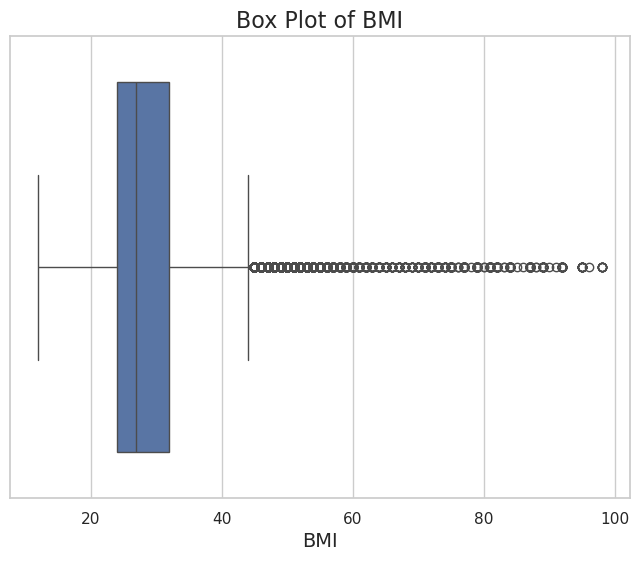

In [562]:
sns.set(style="whitegrid")
palette = sns.color_palette("deep")

# Create the box plot for the 'BMI' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=X['BMI'], color=palette[0])

# Add title and labels for clarity
plt.title('Box Plot of BMI', fontsize=16)
plt.xlabel('BMI', fontsize=14)

# Show the plot
plt.show()

Well, I know from domain knowledge that heavy weights are actually pretty important for predicting diabetes so they must stay.

## Binary Class Imbalances

### Extract Labels for True/False Utility Function

In [563]:
# Function to extract labels for binary columns
def extract_labels_for_bin_cols(bin_cols):
    labels = {}
    for col in bin_cols:
        description = variables[variables['name'] == col]['description'].values[0]
        meanings = re.findall(r'(\d) = ([^\d]+?)(?= \d|$)', description)
        false_meaning = meanings[0][1].strip() if len(meanings) > 0 else "False"
        true_meaning = meanings[1][1].strip() if len(meanings) > 1 else "True"
        labels[col] = (false_meaning, true_meaning)
    return labels

In [564]:
binary_labels = extract_labels_for_bin_cols(bin_cols)

### Plot Binary Class Balances

In [565]:
def plot_binary_class_balances(bin_cols,dfX=X):
    # Set the style with a more widely available font and a light blue background
    sns.set(style="whitegrid", font="DejaVu Sans", rc={"axes.facecolor": "#EAF2F8", "figure.facecolor": "#EAF2F8"})
    custom_palette = ["#E1D7C6","#4A90E2"]  # Medical light blue and gray
    
    # Calculate the number of rows needed based on the number of columns
    n_cols = 3  # Three plots per row
    n_rows = (len(bin_cols) + n_cols - 1) // n_cols  # Ceiling division to determine rows
    
    # Create a figure to hold all subplots
    plt.figure(figsize=(18, n_rows * 6))
    
    # Iterate through each binary column
    for i, col in enumerate(bin_cols):
        plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each binary column
        
        # Calculate the proportion of each class
        value_counts = dfX[col].value_counts(normalize=True).sort_index()
        
        # Get the actual labels from the global binary_labels variable
        false_label, true_label = binary_labels[col]
        labels = [false_label, true_label]
        
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Label': labels,
            'Proportion': value_counts.values,
            'Category': labels
        })
        
        # Create a bar plot with the actual labels using hue and palette
        sns.barplot(x='Label', y='Proportion', hue='Category', data=plot_data,
                    palette=custom_palette, dodge=False, edgecolor=".2", linewidth=1.5)
        
        # Add title and labels
        plt.title(f'Class Balance for {col}', fontsize=16, fontweight='bold')
        plt.xlabel('', fontsize=12)
        plt.ylabel('Proportion', fontsize=12)
        plt.ylim(0, 1.05)  # Set y-axis to go slightly above 1 to prevent percentage overlap
        # Adjust x-tick labels for size and weight
        plt.xticks(fontsize=12, fontweight='bold')
        
        # Display the percentages on the bars with padding to avoid bleeding
        for index, value in enumerate(value_counts.values):
            plt.text(index, value + 0.02, f'{value:.2%}', ha='center', fontsize=12, color='black', fontweight='bold')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)  # Add padding around the subplots

    # Show the plot
    plt.show()

### Binary Class Balances

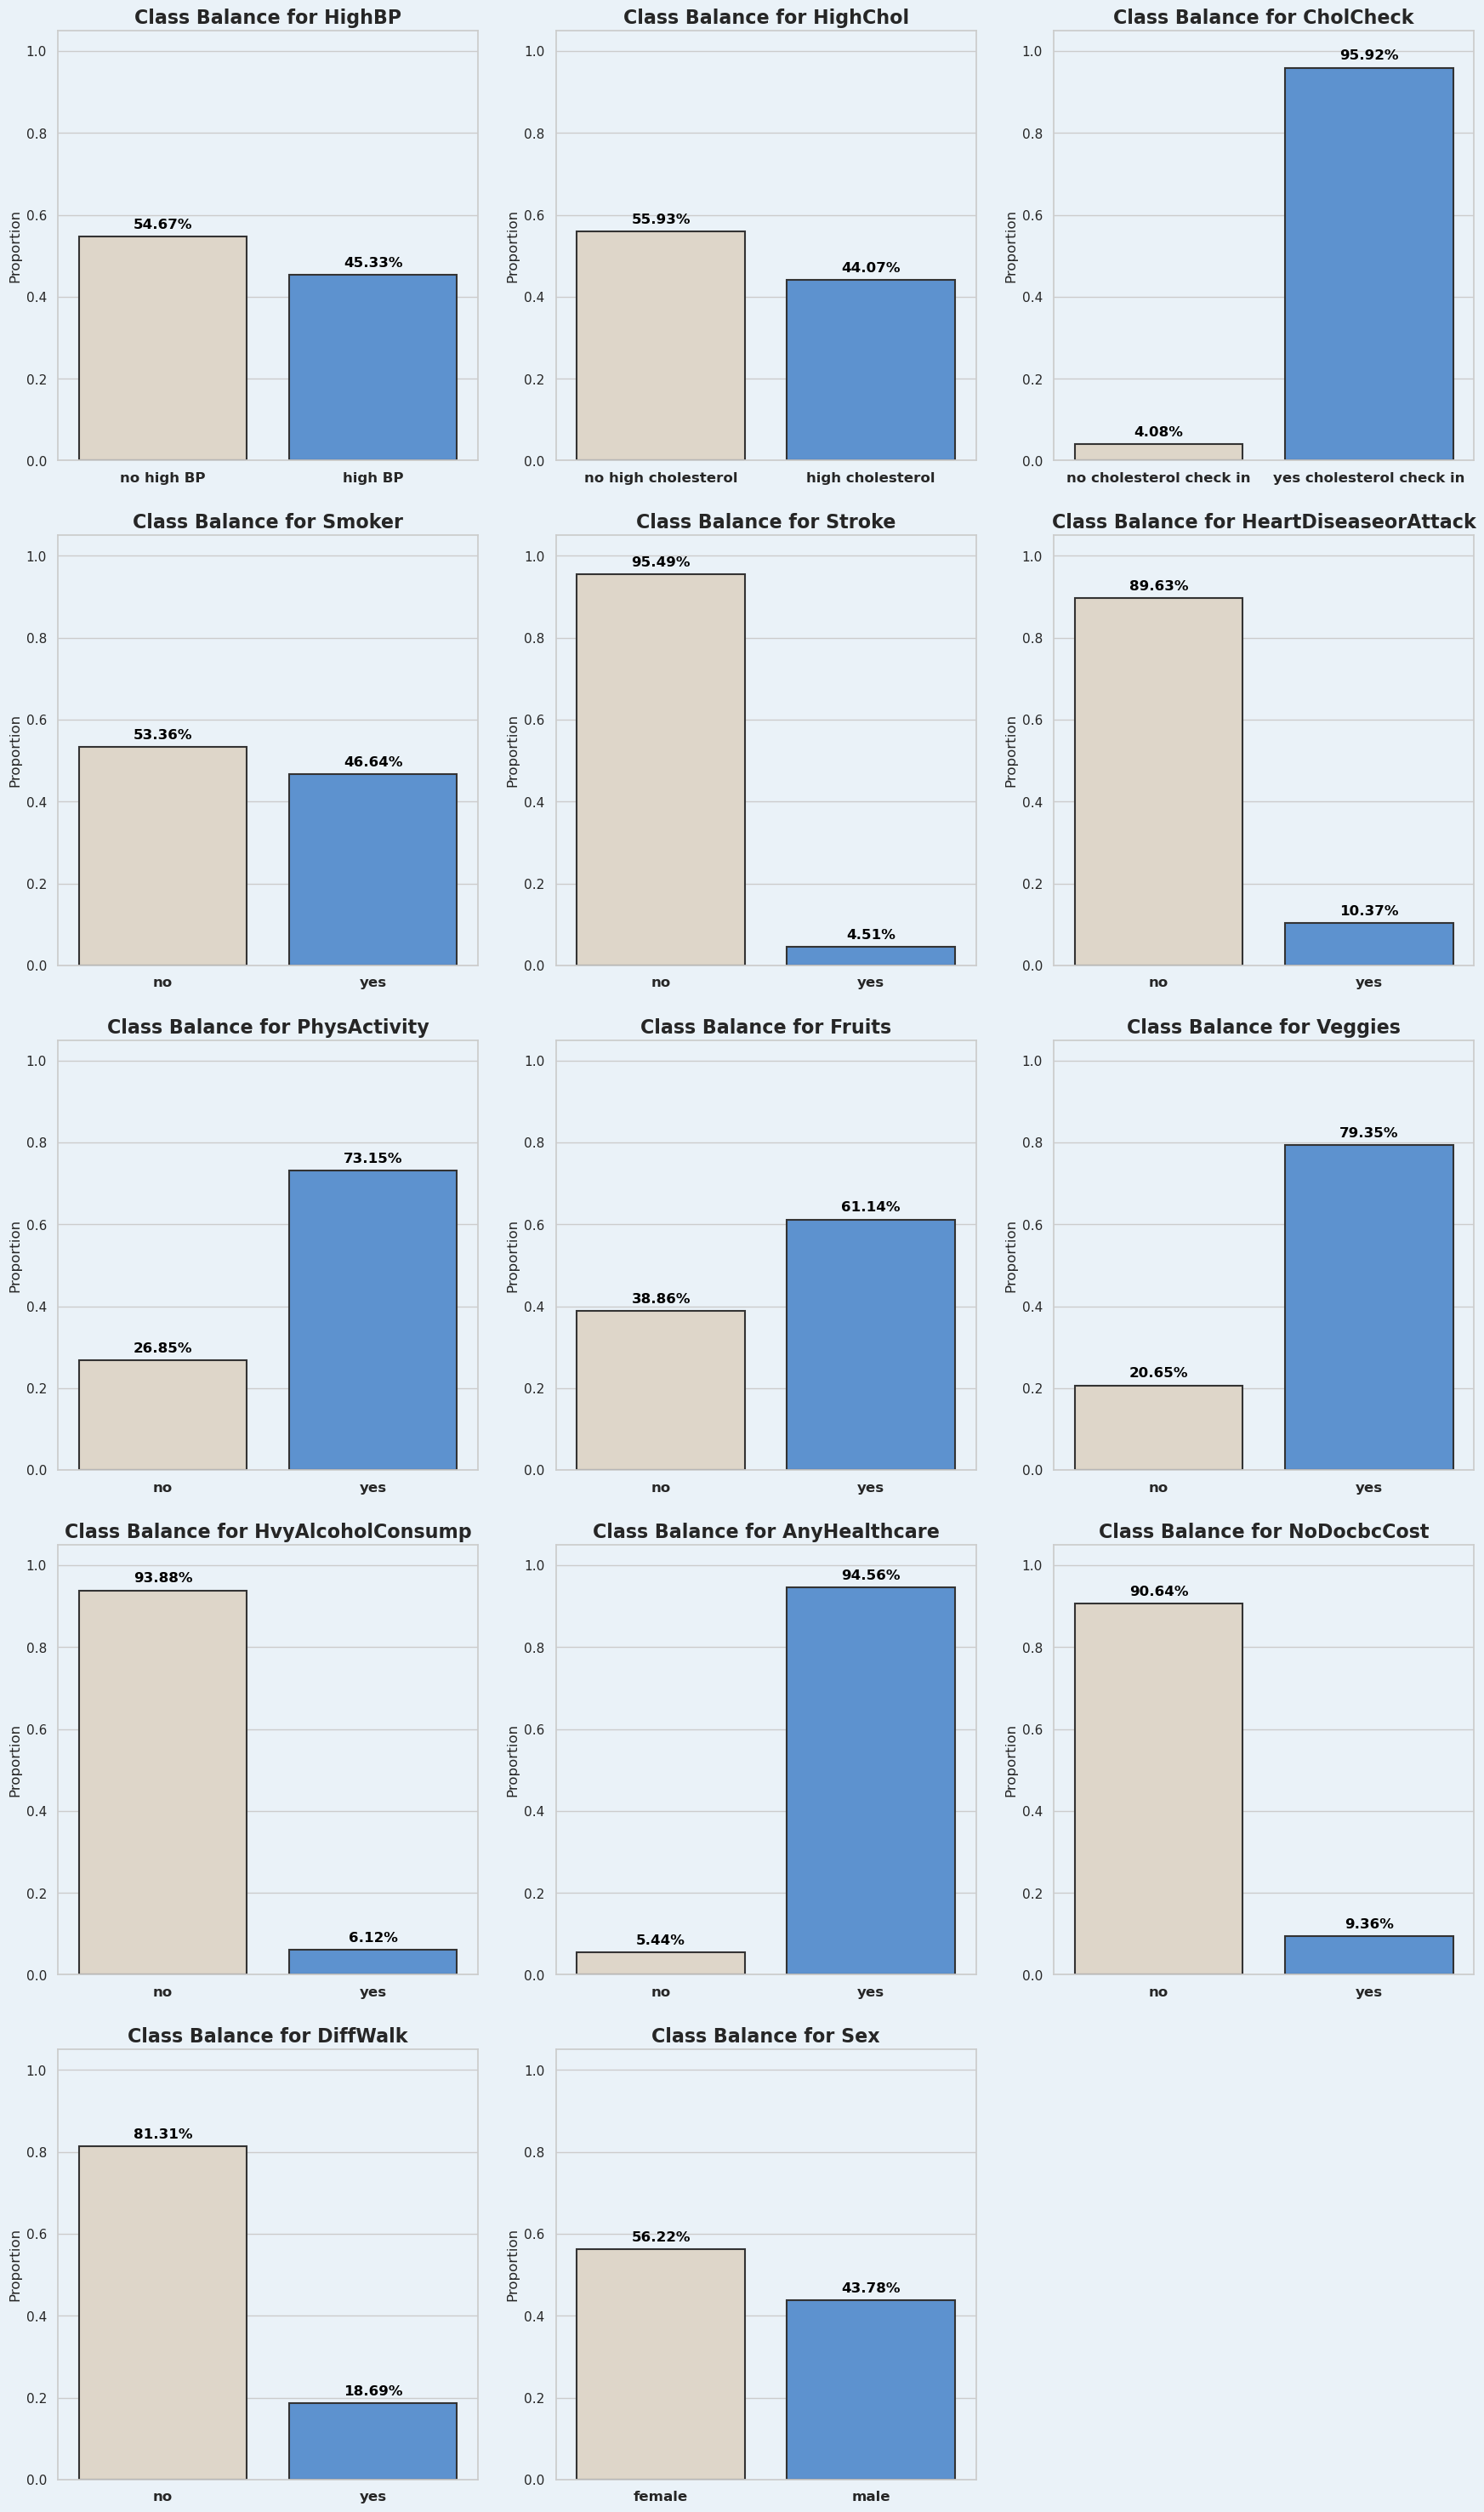

In [566]:
plot_binary_class_balances(bin_cols)

### Analysis of Class Balances

#### HighBP
HighBP shows a fairly even distribution. 

#### HighChol
HighChol shows a fairly even distribution.

#### CholCheck
CholCheck is highly imbalanced, with 95.92% having had a cholesterol check. Important but really hard to balance.

#### Smoker
Smoker is fairly balanced (53.36% no, 46.64% yes).

#### Stroke
Stroke is extremely imbalanced, with only 4.51% reporting a stroke. It is however really useful info.  Can try a drop possibly.

#### HeartDiseaseorAttack
HeartDiseaseorAttack has a notable imbalance (89.63% no, 10.37% yes), but is a critical predictor.

#### PhysActivity
PhysActivity shows a slight imbalance with 73.15% reporting physical activity.  However it is critical.

#### Fruits
Fruits consumption is somewhat imbalanced, with 61.14% reporting daily consumption. Keep as is.

#### Veggies
Veggies consumption is more imbalanced (79.35% yes, 20.65% no). Still critical to keep.

#### HvyAlcoholConsump
Heavy alcohol consumption is highly imbalanced, with only 6.12% reporting it. It is however important to keep.

#### AnyHealthcare
AnyHealthcare is imbalanced, with 94.56% having healthcare coverage. This is a really hard one to call, it could be an indicator for sure though.

#### NoDocbcCost
NoDocbcCost indicates a strong imbalance, with only 9.36% reporting inability to see a doctor due to cost. This is still maybe important but it and AnyHealthCare may be candidates for dropping if model performance is in question.

#### DiffWalk
DiffWalk shows an imbalance where 18.69% report difficulty walking. This is an important feature.

#### Sex
Sex is relatively balanced (56.22% female, 43.78% male), we'll have to see how much of a predictor it is, some diseases are more common in one sex or the other.

## Feature Importance and Correlations

### Target to Features Correlations

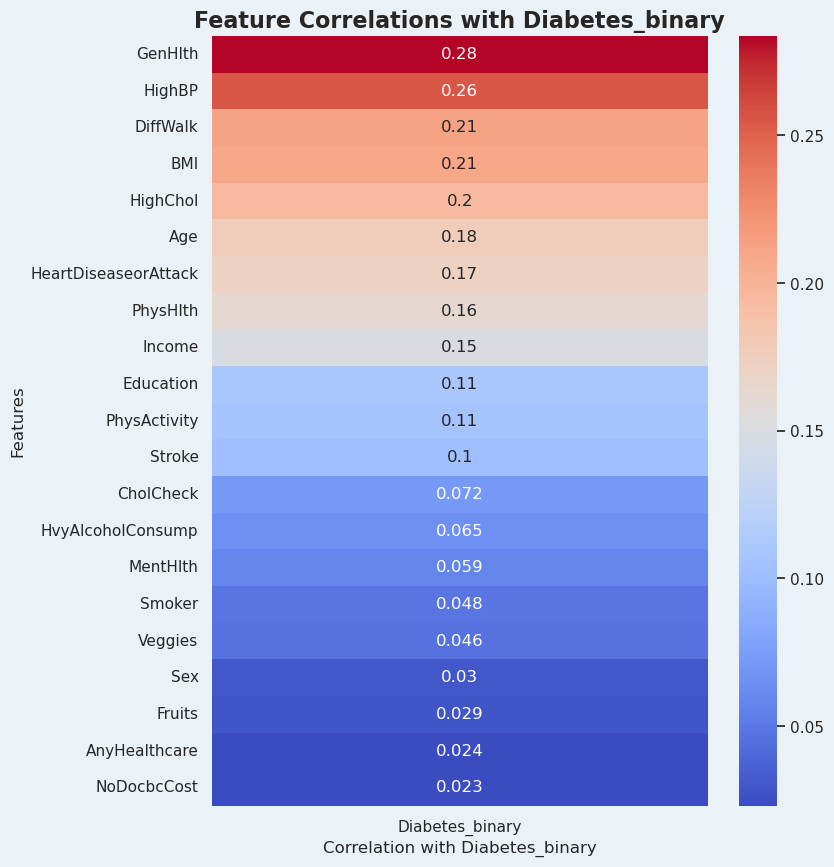

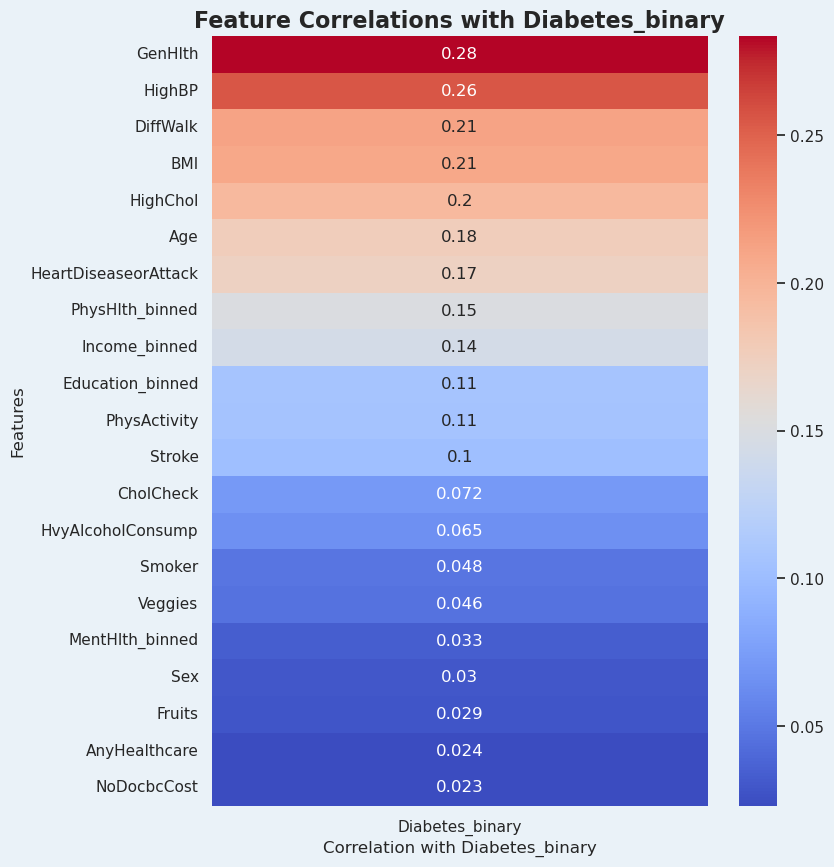

In [567]:
def feature_to_target_correlation_heatmap(X, y):
    # Combine X and y into a single DataFrame
    df = pd.concat([X, y], axis=1)
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Select the correlation of features with the target variable 'Diabetes_binary'
    target_corr = corr_matrix['Diabetes_binary']
    
    # Drop the target itself from the correlation list
    target_corr = target_corr.drop(index='Diabetes_binary')
    
    # Sort the correlations by absolute value
    target_corr_sorted = target_corr.abs().sort_values(ascending=False)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 10))
    sns.heatmap(target_corr_sorted.to_frame(), annot=True, cmap='coolwarm', cbar=True)
    plt.title('Feature Correlations with Diabetes_binary', fontsize=16, fontweight='bold')
    plt.xlabel('Correlation with Diabetes_binary')
    plt.ylabel('Features')
    plt.show()

# Assuming X is your features DataFrame and y is your target variable
feature_to_target_correlation_heatmap(X.drop(columns=rebinned_features), y)
feature_to_target_correlation_heatmap(X.drop(columns=unrebinned_features), y)

### Feature Importance

/tmp/ipykernel_1281348/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


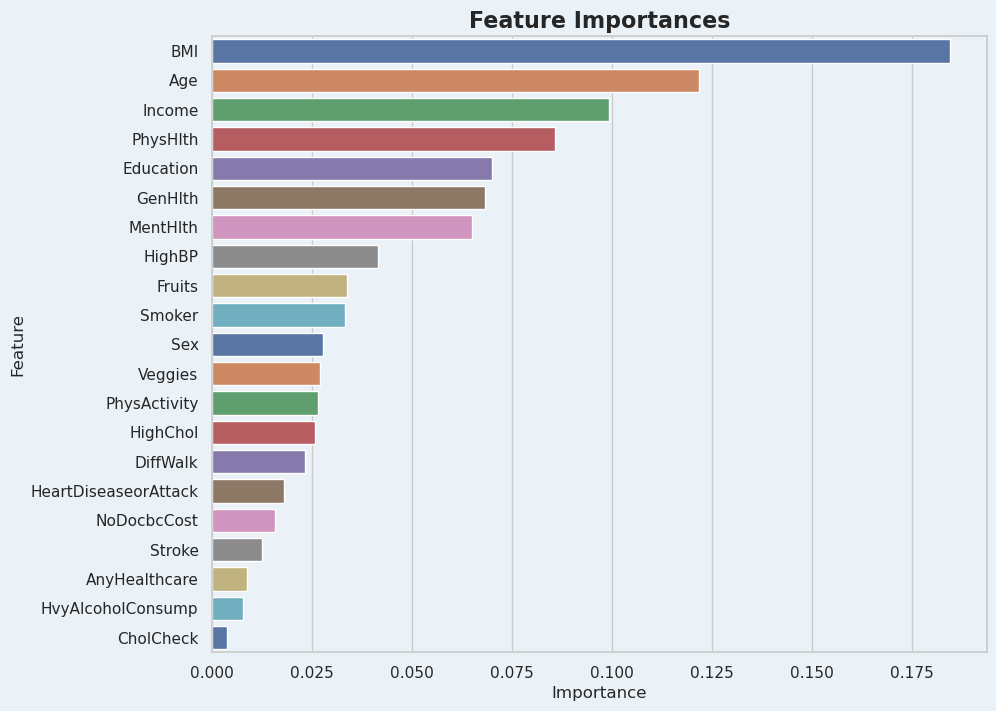

/tmp/ipykernel_1281348/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


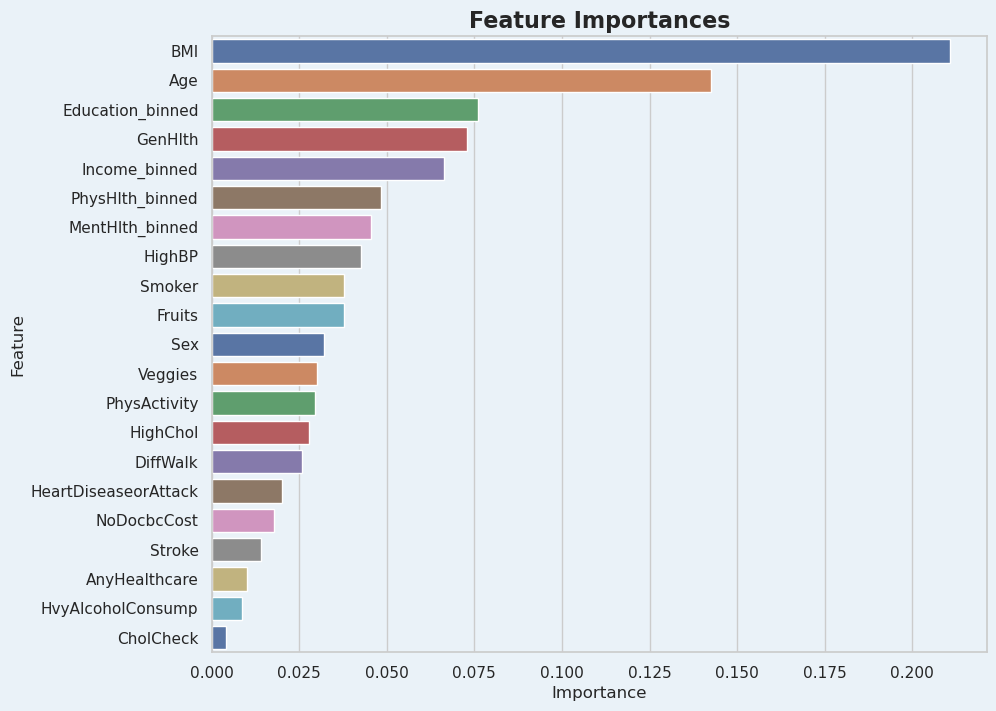

In [568]:
def calculate_feature_importance(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Calculate feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)

    plt.title('Feature Importances', fontsize=16, fontweight='bold')
    plt.show()
    
    return feature_importance_df

# Calculate and display the feature importances
orig_feature_importances = calculate_feature_importance(X.drop(columns=rebinned_features), y)
feature_importances = calculate_feature_importance(X.drop(columns=unrebinned_features), y)

### Compare _binned to non binned

#### 1. **PhysHlth vs. PhysHlth_binned:**
   - **Correlation with Target:**
     - **PhysHlth**: 0.16
     - **PhysHlth_binned**: 0.15
   - **Feature Importance:**
     - **PhysHlth**: Higher in importance than `PhysHlth_binned`.

   **Conclusion:** **PhysHlth** is stronger.

#### 2. **MentHlth vs. MentHlth_binned:**
   - **Correlation with Target:**
     - **MentHlth**: 0.033
     - **MentHlth_binned**: 0.059
   - **Feature Importance:**
     - **MentHlth_binned**: Higher in importance than `MentHlth`.

   **Conclusion:** **MentHlth_binned** is stronger.

#### 3. **Income vs. Income_binned:**
   - **Correlation with Target:**
     - **Income**: 0.14
     - **Income_binned**: 0.14
   - **Feature Importance:**
     - **Income_binned**: Higher in importance than `Income`.

   **Conclusion:** **Income_binned** is stronger.

#### 4. **Education vs. Education_binned:**
   - **Correlation with Target:**
     - **Education**: 0.11
     - **Education_binned**: 0.11
   - **Feature Importance:**
     - **Education_binned**: Higher in importance than `Education`.

   **Conclusion:** **Education_binned** is stronger.

#### Overall Comparison:
- **Stronger When Binned**: `MentHlth`, `Income`, and `Education` have stronger predictive power when binned.
- **Stronger in Original Form**: `PhysHlth` is slightly stronger in its original form.

#### Summary:
Most of the binned features (`MentHlth_binned`, `Income_binned`, and `Education_binned`) perform better than being unbinned with the exception of `PhysHlth`.  Since the change to `PhysHlth` is small, and it helps class imbalance a lot, I will be using it binned too and drop the original columns.

### Drop unrebinned


In [569]:
X.drop(columns=unrebinned_features,inplace=True,errors='ignore')
X.columns.to_list()


['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'MentHlth_binned',
 'PhysHlth_binned',
 'Education_binned',
 'Income_binned']

### Feature to Feature Correlations

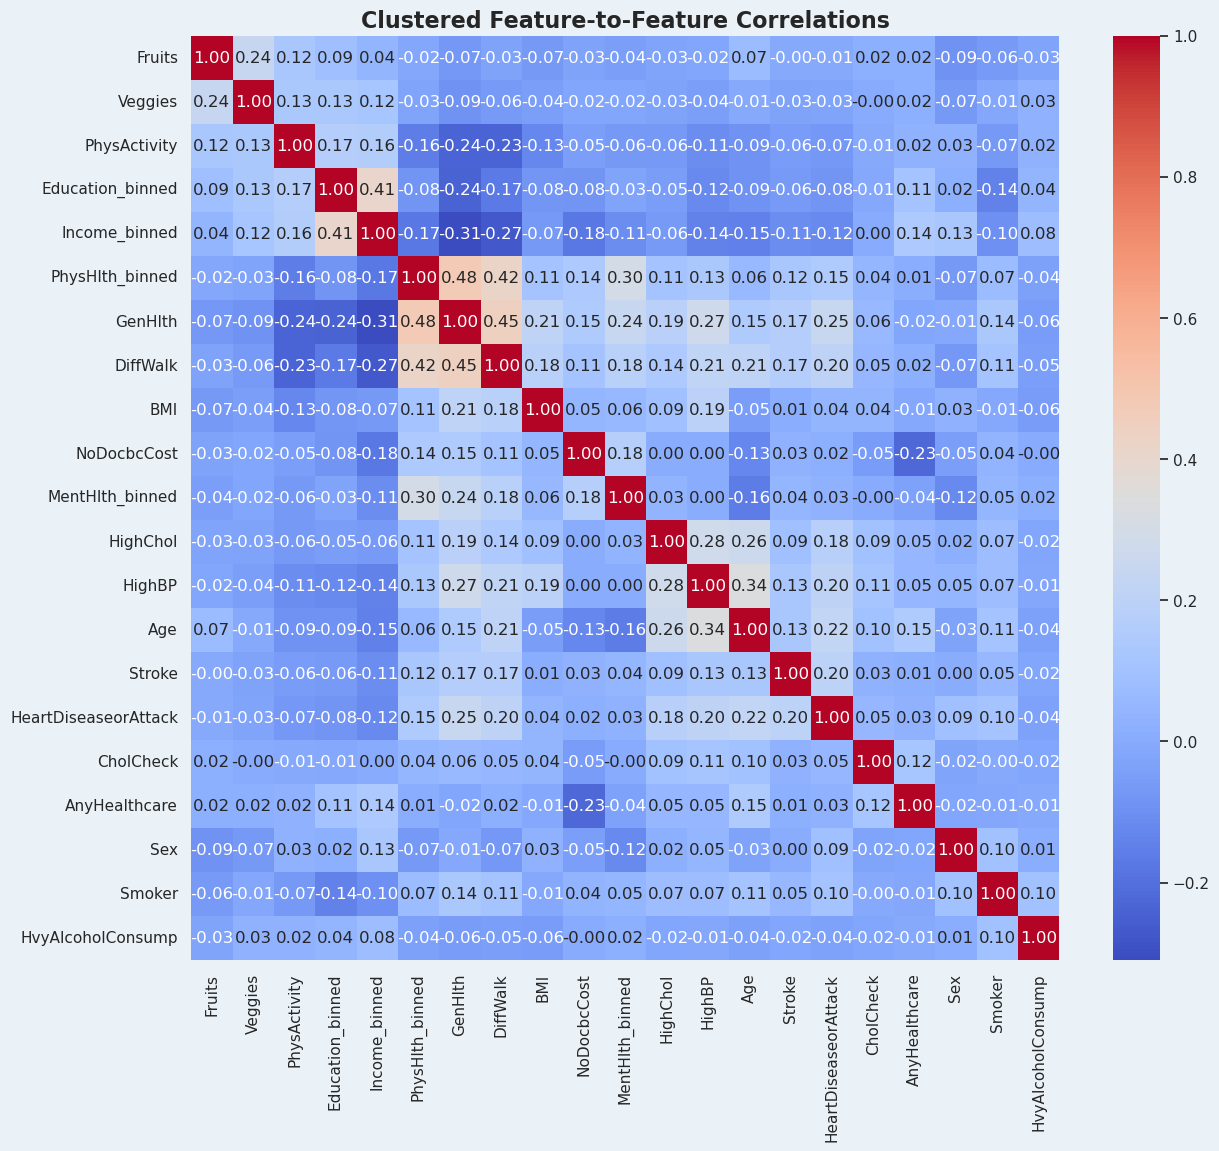

In [570]:
def feature_to_feature_correlations(X):
    # Calculate the correlation matrix
    corr_matrix = X.corr()
    
    # Perform hierarchical clustering on the correlation matrix
    linkage_matrix = linkage(corr_matrix, method='ward')  # You can also use other methods like 'average'
    
    # Get the order of the features after clustering
    ordered_indices = leaves_list(linkage_matrix)
    ordered_columns = corr_matrix.columns[ordered_indices]
    
    # Reorder the correlation matrix
    ordered_corr_matrix = corr_matrix.loc[ordered_columns, ordered_columns]
    
    # Use a heatmap to visualize the reordered correlations
    plt.figure(figsize=(14, 12))
    sns.heatmap(ordered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title("Clustered Feature-to-Feature Correlations", fontsize=16, fontweight='bold')
    plt.show()
    
    return ordered_corr_matrix

# Calculate and display the feature to feature correlations
feature_correlations = feature_to_feature_correlations(X)

## Interaction Effects

In [571]:
# Define the dictionary with features to interact
interaction_dict = {
    'PhysHlth_binned': 'HighBP',
    'BMI': 'Age',
    'PhysActivity': 'BMI',
    'HighChol': 'HighBP',
    'MentHlth_binned': 'DiffWalk',
    'Income_binned': 'Education_binned',
    'Fruits': 'Veggies',
    'Smoker': 'HvyAlcoholConsump',
    'PhysHlth_binned': 'DiffWalk',
    'GenHlth': 'AnyHealthcare'
}

# Initialize an empty list to store the names of the interaction columns
interaction_cols = []

# Loop through the dictionary to create interaction features
for key, value in interaction_dict.items():
    interaction_name = f'{key}_{value}_interaction'
    X[interaction_name] = X[key] * X[value]
    interaction_cols.append(interaction_name)

# Display the list of created interaction columns
print(interaction_cols)

['PhysHlth_binned_DiffWalk_interaction', 'BMI_Age_interaction', 'PhysActivity_BMI_interaction', 'HighChol_HighBP_interaction', 'MentHlth_binned_DiffWalk_interaction', 'Income_binned_Education_binned_interaction', 'Fruits_Veggies_interaction', 'Smoker_HvyAlcoholConsump_interaction', 'GenHlth_AnyHealthcare_interaction']


### Interaction Importances

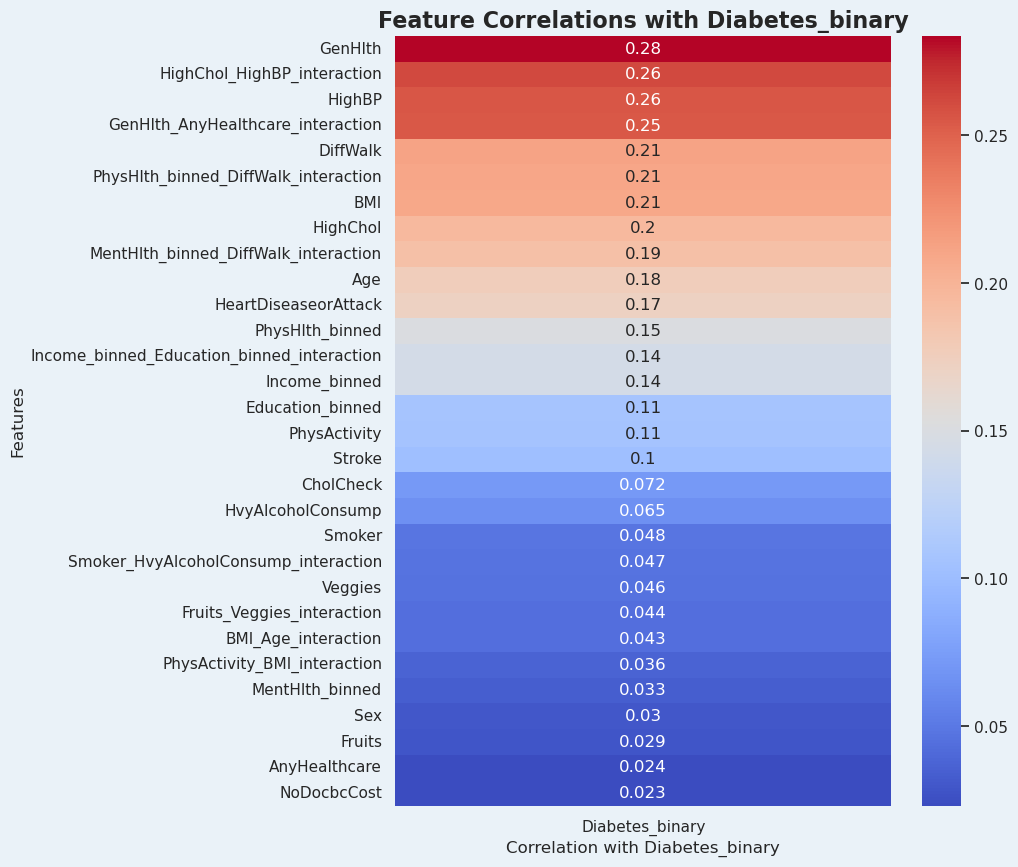

In [572]:
feature_to_target_correlation_heatmap(X,y)

/tmp/ipykernel_1281348/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


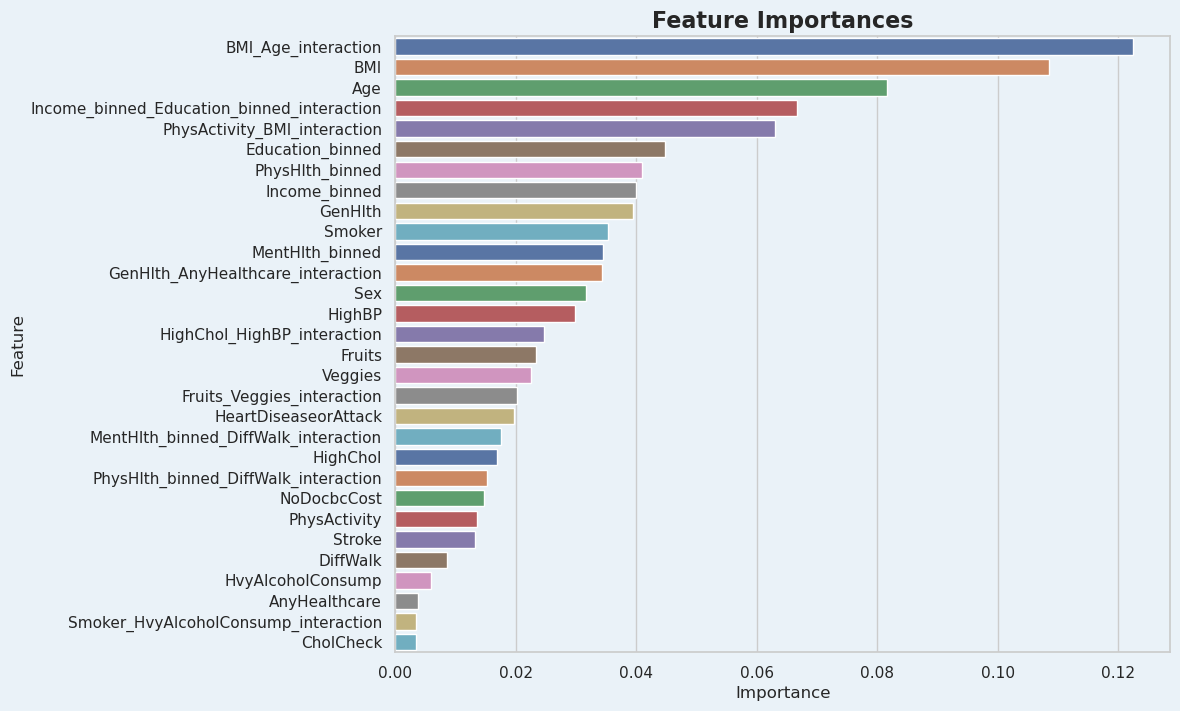

In [573]:
int_feature_importances = calculate_feature_importance(X, y)

# Sampling For Balance

## Initial Balance

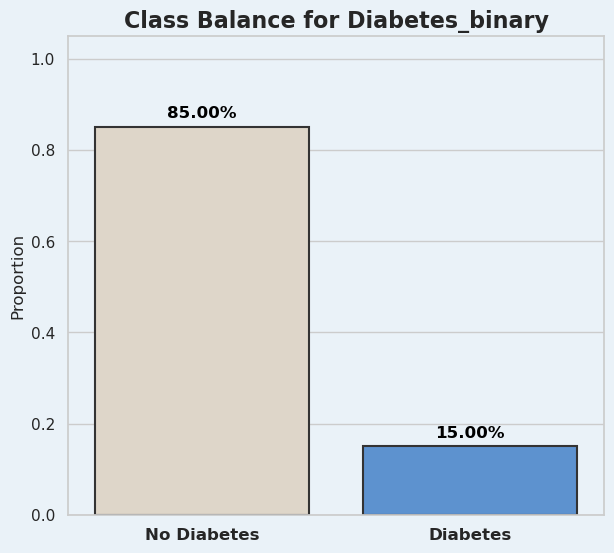

In [585]:

plot_binary_class_balances(['Diabetes_binary'], y)


## Undersample Balance

(68358, 1)

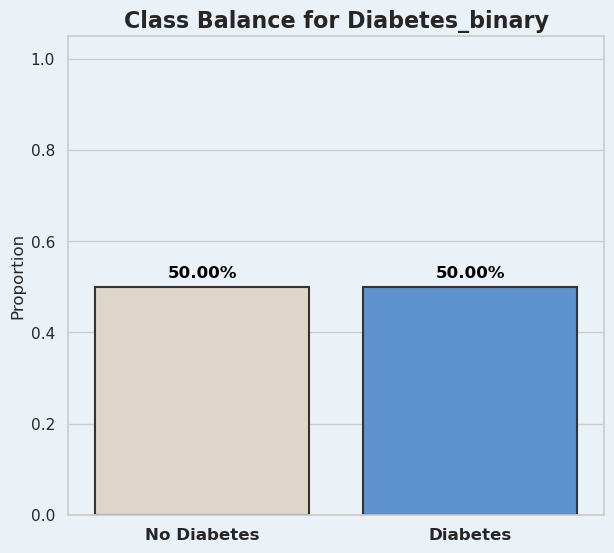

In [586]:

# Separate the majority and minority classes
majority_class = y[y['Diabetes_binary'] == 0]
minority_class = y[y['Diabetes_binary'] == 1]

# Undersample the majority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,  # sample without replacement
                                       n_samples=len(minority_class),  # match minority class
                                       random_state=42)  # reproducible results

# Combine the undersampled majority class with the minority class
undersampled_dataset = pd.concat([majority_class_undersampled, minority_class])
display(undersampled_dataset.shape)

# Plot the class balance for the target variable
plot_binary_class_balances(['Diabetes_binary'], undersampled_dataset)


Great!  Now we are ready to split the data and then model

# Test Train Split

In [588]:
# Extract the features (uX) and target (uy) from the undersampled dataset
uX = X.loc[undersampled_dataset.index]
uy = undersampled_dataset

# Perform the test/train split
uX_train, uX_test, uy_train, uy_test = train_test_split(uX, uy, test_size=0.2, random_state=42, stratify=uy)

# Display the shape of the resulting splits
print("Train set size:", uX_train.shape)
print("Test set size:", uX_test.shape)

Train set size: (54686, 30)
Test set size: (13672, 30)


# Utility Functions

In [612]:
def display_classification_report(y_true, y_pred, title="Classification Report"):
    # Generate the classification report as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["No Diabetes", "Diabetes"])
    
    # Convert the dictionary to a pandas DataFrame for nicer formatting
    report_df = pd.DataFrame(report).transpose()

    # Display the classification report
    print(title)
    display(report_df)

In [619]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC AUC
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Scores
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    # Define colors based on Seaborn palettes
    train_color = sns.color_palette("muted")[0]  # Typically blue in muted palette
    test_color = sns.color_palette("deep")[2]    # Typically red in deep palette
    
    # Plotting
    fig = plt.figure(figsize=(14, 16))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.5])
    
    # ROC AUC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    ax1.plot(fpr_train, tpr_train, label=f'Train ROC AUC: {train_auc:.4f}', color=train_color)
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_title('ROC AUC Curve - Train', fontsize=16)
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(gs[0, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    ax2.plot(fpr_test, tpr_test, label=f'Test ROC AUC: {test_auc:.4f}', color=test_color)
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_title('ROC AUC Curve - Test', fontsize=16)
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.legend(loc='lower right')
    
    # Confusion Matrices
    ax3 = fig.add_subplot(gs[1, 0])
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap=sns.light_palette(train_color, as_cmap=True), ax=ax3)
    ax3.set_title("Train Confusion Matrix", fontsize=16)
    ax3.set_xlabel("Predicted Label", fontsize=12)
    ax3.set_ylabel("True Label", fontsize=12)

    ax4 = fig.add_subplot(gs[1, 1])
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap=sns.light_palette(test_color, as_cmap=True), ax=ax4)
    ax4.set_title("Test Confusion Matrix", fontsize=16)
    ax4.set_xlabel("Predicted Label", fontsize=12)
    ax4.set_ylabel("True Label", fontsize=12)

    plt.tight_layout()
    plt.show()

    # Generate and display the classification report for the train set
    display_classification_report(uy_train, y_train_pred, title="Train Classification Report")

    # Generate and display the classification report for the test set
    display_classification_report(uy_test, y_test_pred, title="Test Classification Report")
    

# First Simple Model

In [609]:

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
log_reg.fit(uX_train, uy_train)

# Make predictions on the test set
uy_pred = log_reg.predict(uX_test)


/home/atrix/anaconda3/envs/cuda_deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


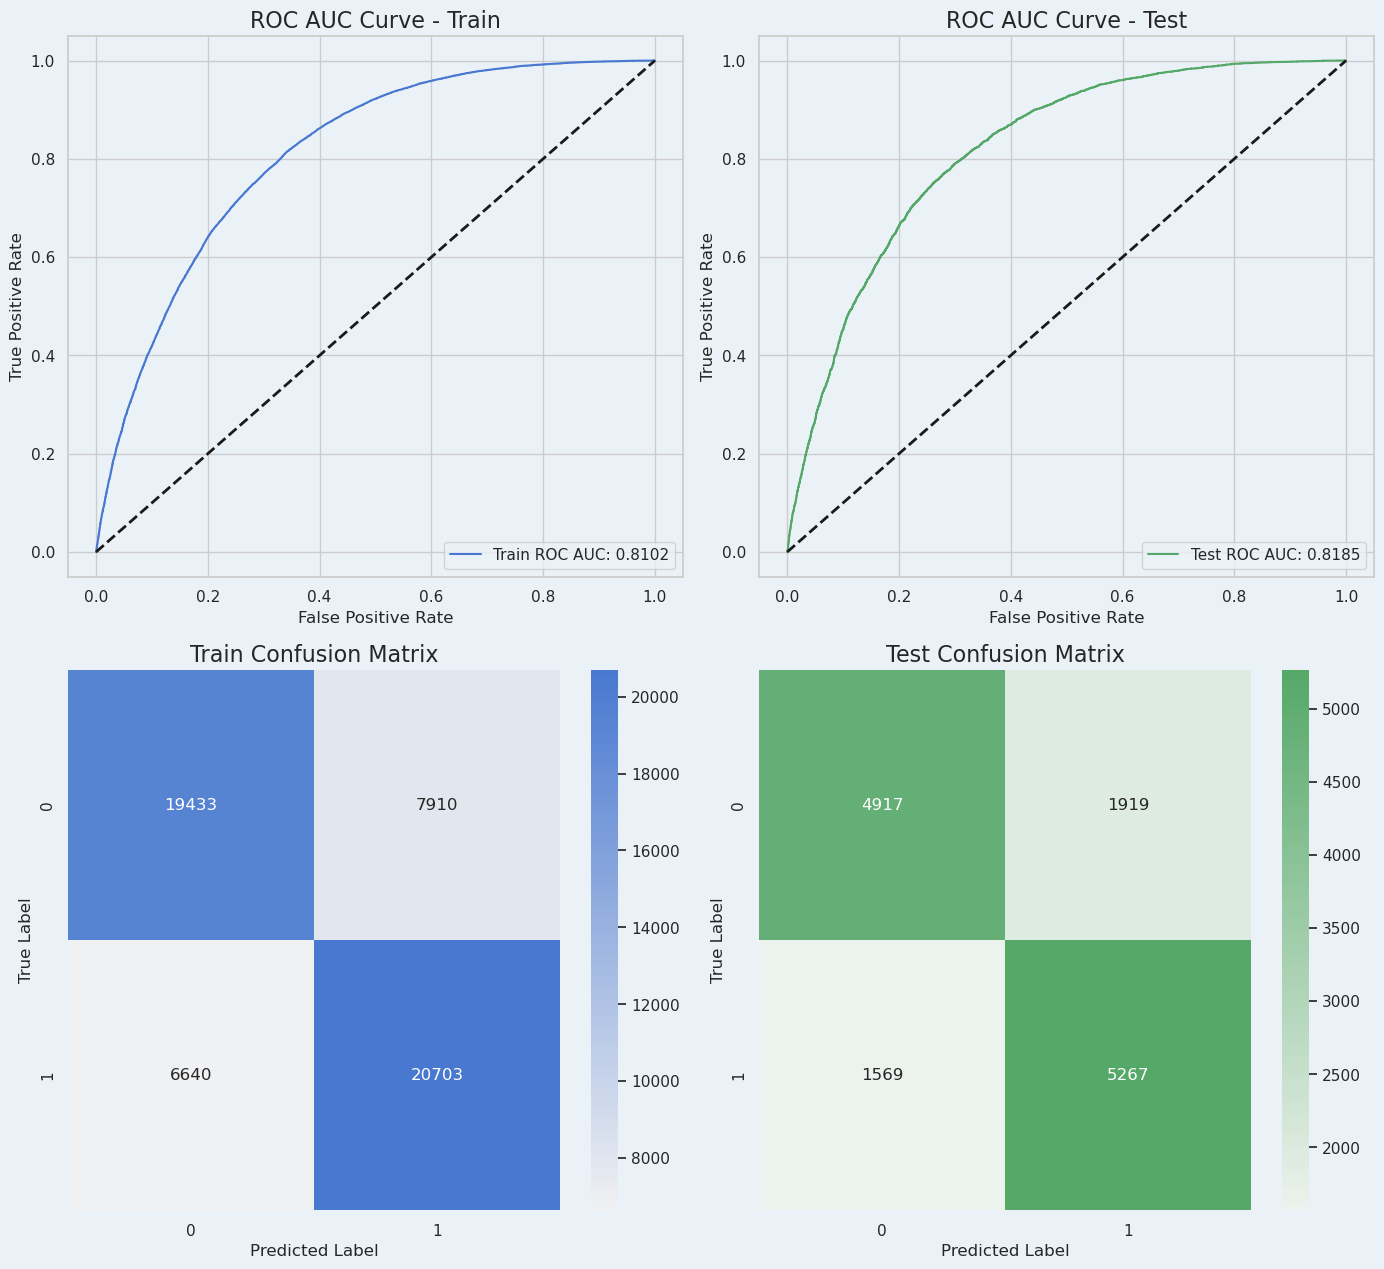

Train Classification Report


,precision,recall,f1-score,support
No Diabetes,0.745330,0.710712,0.727610,27343.000000
Diabetes,0.723552,0.757159,0.739974,27343.000000
accuracy,0.733936,0.733936,0.733936,0.733936
macro avg,0.734441,0.733936,0.733792,54686.000000
weighted avg,0.734441,0.733936,0.733792,54686.000000


Test Classification Report


,precision,recall,f1-score,support
No Diabetes,0.758094,0.71928,0.738177,6836.00000
Diabetes,0.732953,0.77048,0.751248,6836.00000
accuracy,0.744880,0.74488,0.744880,0.74488
macro avg,0.745524,0.74488,0.744713,13672.00000
weighted avg,0.745524,0.74488,0.744713,13672.00000


In [620]:
# Evaluate the model
evaluate_model(log_reg, uX_train, uy_train, uX_test, uy_test)